In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
import missingno as msno
from datetime import timedelta
import sys
import os
import math
from scipy.stats import t
import time
import datetime
import warnings

In [2]:
# # 구글 드라이브에 마운트 해주기
# from google.colab import drive
# drive.mount('/content/drive')

# # 작업 디렉토리 변경
# os.chdir("/content/drive/MyDrive/Edge box anomaly detection paper/전체 코드 및 데이터 일괄 정리")

In [3]:
# 데이터프레임 불러오기
df_worker = pd.DataFrame(pd.read_csv('worker_202309251148.csv', index_col=False))
print('패치 등록 인원 수 :', df_worker['smart_patch'].nunique())
print(df_worker['smart_patch'].value_counts())

패치 등록 인원 수 : 115
SmartPatch_962E    2
SmartPatch_8032    1
SmartPatch_A86A    1
SmartPatch_7A66    1
SmartPatch_5226    1
                  ..
SmartPatch_C06E    1
SmartPatch_EFDE    1
SmartPatch_F016    1
SmartPatch_9EE2    1
SmartPatch_A826    1
Name: smart_patch, Length: 115, dtype: int64


<span style="font-size:28px;">**** 등록 디바이스 중복 확인***</span>
- SmartPatch_962E 패치 하나를 2명이 등록함

In [4]:
warnings.filterwarnings("ignore")
# 데이터프레임 불러오기
df = pd.DataFrame(pd.read_csv('smart_patch_health_data_202309251132.csv', index_col=False))
print('DB에 수집된 패치 인원 수 :', df['mac'].nunique())

DB에 수집된 패치 인원 수 : 104


<span style="font-size:28px;">**** Column 설명***</span>

id = DB 인덱스  
arrhythmia = 부정맥 감지 여부, 1일때 감지, rr_interval data 에만 표시  
data_interval = 데이터 간격 50mmsec, 부정맥, 낙상 데이터에만 표시, 모두 50으로 고정  
ecg_raw = 부정맥 감지 시점 기준으로 전후 ECG 값  
end_date_time = 각각의 rr 데이터의 끝 시간, rr_interval data 에만 표시  
fall_detection = 낙상 감지 여부, 1일때 감지, rr_interval data 에만 표시  
flag = 1 : rr_interval data, 2 : fall data, 3 : arrhythmia data  
mac = 패치 디바이스의 mac 주소  
machine_id = 패치 디바이스의 ID  
rr_interval = rr 데이터  
start_date_time = 데이터의 시작 시간  
value = 낙상 벡터값  
x = 센서 ax값  
y = 센서 ay값  
z = 센서 az값  
created_date = DB 저장 시간  

# rr 인터벌 데이터만 확인 (flag = 1)

In [5]:

df = df[df['flag'] == 1]
df = df[['mac', 'machine_id', 'arrhythmia', 'fall_detection', 'start_date_time', 'rr_interval', 'end_date_time', 'created_date']]
df

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date
0,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:51.000,4095.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000
1,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55.000,812.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000
2,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55.000,812.0,2023-09-12 10:05:56.000,2023-09-12 10:13:14.000
3,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:56.000,804.0,2023-09-12 10:05:57.000,2023-09-12 10:13:14.000
4,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:57.000,768.0,2023-09-12 10:05:58.000,2023-09-12 10:13:14.000
...,...,...,...,...,...,...,...,...
18393584,8C:CE:4E:BB:B0:56,NaN,1.0,1.0,2023-09-25 08:07:49.000,432.0,2023-09-25 08:07:49.000,2023-09-25 08:08:23.000
18393586,8C:CE:4E:BB:B0:56,NaN,0.0,0.0,2023-09-25 08:07:49.000,1545.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000
18393587,8C:CE:4E:BB:B0:56,NaN,1.0,0.0,2023-09-25 08:07:51.000,400.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000
18393588,8C:CE:4E:BB:B0:56,NaN,0.0,0.0,2023-09-25 08:07:51.000,2160.0,2023-09-25 08:07:53.000,2023-09-25 08:08:23.000


# 데이터 확인 : 누락 및 이상 데이터

In [6]:
column = 'start_date_time'
df[column] = pd.to_datetime(df[column])
# 연월일 추가
df["date"] =df[column].dt.date
# 연도 추가
df["year"] = df[column].dt.year
# 월 추가
df["month"] = df[column].dt.month
# 일 추가
df["day"] = df[column].dt.day
# time 추가
df["time"] = df[column].dt.time
# 시간 추가
df["hour"] = df[column].dt.hour
# 분 추가
df["minute"] = df[column].dt.minute
# 초 추가
df["second"] = df[column].dt.second
# 마이크로초 추가
# df["microsecond"] = df[column].dt.microsecond
# 요일 추가
df["week"] = df[column].dt.day_name()
# 요일 숫자 추가
# df["week_cnt"] = df[column].dt.weekday
# 해당월의 시작인가
# df["start_day"] = df[column].dt.is_month_start
# 해당월의 끝인가
# df["end_day"] = df[column].dt.is_month_end
df

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
0,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:51,4095.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:51,10,5,51,Tuesday
1,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
2,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:56.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
3,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:56,804.0,2023-09-12 10:05:57.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:56,10,5,56,Tuesday
4,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:57,768.0,2023-09-12 10:05:58.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:57,10,5,57,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393584,8C:CE:4E:BB:B0:56,NaN,1.0,1.0,2023-09-25 08:07:49,432.0,2023-09-25 08:07:49.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393586,8C:CE:4E:BB:B0:56,NaN,0.0,0.0,2023-09-25 08:07:49,1545.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393587,8C:CE:4E:BB:B0:56,NaN,1.0,0.0,2023-09-25 08:07:51,400.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday
18393588,8C:CE:4E:BB:B0:56,NaN,0.0,0.0,2023-09-25 08:07:51,2160.0,2023-09-25 08:07:53.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday


In [7]:
# 디바이스 이름이 없는 경우 확인
df[df['machine_id'].isnull()]

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
73155,24:4C:AB:83:F0:4A,NaN,0.0,0.0,2023-09-12 15:48:03,4095.0,NaN,2023-09-12 15:48:18.000,2023-09-12,2023,9,12,15:48:03,15,48,3,Tuesday
187862,0C:DC:7E:57:96:52,NaN,0.0,0.0,2023-09-12 06:02:05,536.0,2023-09-12 06:02:05.000,2023-09-12 16:05:07.000,2023-09-12,2023,9,12,06:02:05,6,2,5,Tuesday
187863,0C:DC:7E:57:96:52,NaN,0.0,0.0,2023-09-12 06:02:05,552.0,2023-09-12 06:02:06.000,2023-09-12 16:05:07.000,2023-09-12,2023,9,12,06:02:05,6,2,5,Tuesday
187864,0C:DC:7E:57:96:52,NaN,0.0,0.0,2023-09-12 06:02:06,556.0,2023-09-12 06:02:06.000,2023-09-12 16:05:07.000,2023-09-12,2023,9,12,06:02:06,6,2,6,Tuesday
187865,0C:DC:7E:57:96:52,NaN,0.0,0.0,2023-09-12 06:02:06,1624.0,2023-09-12 06:02:08.000,2023-09-12 16:05:07.000,2023-09-12,2023,9,12,06:02:06,6,2,6,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393584,8C:CE:4E:BB:B0:56,NaN,1.0,1.0,2023-09-25 08:07:49,432.0,2023-09-25 08:07:49.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393586,8C:CE:4E:BB:B0:56,NaN,0.0,0.0,2023-09-25 08:07:49,1545.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393587,8C:CE:4E:BB:B0:56,NaN,1.0,0.0,2023-09-25 08:07:51,400.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday
18393588,8C:CE:4E:BB:B0:56,NaN,0.0,0.0,2023-09-25 08:07:51,2160.0,2023-09-25 08:07:53.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday


In [8]:
print('디바이스 이름이 하나라도 없는 디바이스 개수 확인 :', df[df['machine_id'].isnull()]['mac'].nunique())
df[df['machine_id'].isnull()]['mac'].value_counts()

디바이스 이름이 하나라도 없는 디바이스 개수 확인 : 33


0C:DC:7E:57:96:5E    202078
0C:DC:7E:57:A8:1E    188739
24:4C:AB:82:7A:AA    167172
0C:DC:7E:57:96:36    158746
0C:DC:7E:57:96:2E    134305
24:4C:AB:82:51:E6    103264
24:4C:AB:82:52:46    101602
0C:DC:7E:57:A8:32     95170
24:4C:AB:83:EF:FA     83560
24:4C:AB:82:7A:9E     81866
E8:31:CD:5F:A0:7E     61452
24:4C:AB:83:F0:2E     58768
24:4C:AB:83:F0:26     56292
8C:4B:14:6C:1D:52     54021
24:4C:AB:82:7A:76     53791
24:4C:AB:82:52:02     53327
0C:DC:7E:57:96:6A     50039
24:4C:AB:83:F0:82     48490
24:4C:AB:81:FB:8E     46848
0C:DC:7E:54:77:CA     46511
24:4C:AB:81:FB:CE     46059
24:4C:AB:83:F0:22     43940
24:4C:AB:83:F0:0A     36000
0C:DC:7E:57:96:52     35507
24:4C:AB:82:52:42     29340
24:4C:AB:83:EF:DE     10211
24:4C:AB:81:FC:32      1001
24:4C:AB:83:F0:3E       387
24:4C:AB:83:F0:2A       385
0C:DC:7E:57:A8:56       217
24:4C:AB:83:F0:4A        21
24:4C:AB:82:7A:66         7
8C:CE:4E:BB:B0:56         6
Name: mac, dtype: int64

In [9]:
# 특정 디바이스만 확인
df[ (df['mac']== '24:4C:AB:82:7A:66') ]

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
5722511,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:50,684.0,2023-09-12 09:18:50.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:50,9,18,50,Tuesday
5722512,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:50,2820.0,2023-09-12 09:18:53.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:50,9,18,50,Tuesday
5722513,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:53,1380.0,2023-09-12 09:18:54.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:53,9,18,53,Tuesday
5722514,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:54,700.0,2023-09-12 09:18:55.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:54,9,18,54,Tuesday
5722515,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:55,688.0,2023-09-12 09:18:56.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:55,9,18,55,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11997167,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:44,3960.0,2023-09-14 17:06:48.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:44,17,6,44,Thursday
11997170,24:4C:AB:82:7A:66,NaN,1.0,0.0,2023-09-14 17:06:48,460.0,2023-09-14 17:06:49.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:48,17,6,48,Thursday
11997172,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:49,1336.0,2023-09-14 17:06:50.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:49,17,6,49,Thursday
11997175,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:50,1300.0,2023-09-14 17:06:51.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:50,17,6,50,Thursday


In [10]:
# 특정 디바이스만 확인 : machine_id 없는 것만
df[ (df['mac']== '24:4C:AB:82:7A:66') & (df['machine_id'].isnull()) ]

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
11997162,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:40,640.0,2023-09-14 17:06:40.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:40,17,6,40,Thursday
11997166,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:40,4095.0,2023-09-14 17:06:44.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:40,17,6,40,Thursday
11997167,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:44,3960.0,2023-09-14 17:06:48.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:44,17,6,44,Thursday
11997170,24:4C:AB:82:7A:66,NaN,1.0,0.0,2023-09-14 17:06:48,460.0,2023-09-14 17:06:49.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:48,17,6,48,Thursday
11997172,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:49,1336.0,2023-09-14 17:06:50.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:49,17,6,49,Thursday
11997175,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:50,1300.0,2023-09-14 17:06:51.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:50,17,6,50,Thursday
11997178,24:4C:AB:82:7A:66,NaN,0.0,0.0,2023-09-14 17:06:51,4095.0,2023-09-14 17:06:55.000,2023-09-18 08:56:05.000,2023-09-14,2023,9,14,17:06:51,17,6,51,Thursday


In [11]:
# 특정 디바이스만 확인 : machine_id 있는 것만
df[ (df['mac']== '24:4C:AB:82:7A:66') & (df['machine_id'].notna()) ]

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
5722511,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:50,684.0,2023-09-12 09:18:50.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:50,9,18,50,Tuesday
5722512,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:50,2820.0,2023-09-12 09:18:53.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:50,9,18,50,Tuesday
5722513,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:53,1380.0,2023-09-12 09:18:54.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:53,9,18,53,Tuesday
5722514,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:54,700.0,2023-09-12 09:18:55.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:54,9,18,54,Tuesday
5722515,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 09:18:55,688.0,2023-09-12 09:18:56.000,2023-09-14 16:36:41.000,2023-09-12,2023,9,12,09:18:55,9,18,55,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759423,24:4C:AB:82:7A:66,SmartPatch_7A66,0.0,0.0,2023-09-12 15:31:24,512.0,2023-09-12 15:31:24.000,2023-09-14 16:38:33.000,2023-09-12,2023,9,12,15:31:24,15,31,24,Tuesday
5759424,24:4C:AB:82:7A:66,SmartPatch_7A66,1.0,0.0,2023-09-12 15:31:24,400.0,2023-09-12 15:31:24.000,2023-09-14 16:38:33.000,2023-09-12,2023,9,12,15:31:24,15,31,24,Tuesday
5759425,24:4C:AB:82:7A:66,SmartPatch_7A66,1.0,0.0,2023-09-12 15:31:24,400.0,2023-09-12 15:31:25.000,2023-09-14 16:38:33.000,2023-09-12,2023,9,12,15:31:24,15,31,24,Tuesday
5759426,24:4C:AB:82:7A:66,SmartPatch_7A66,1.0,1.0,2023-09-12 15:31:25,476.0,2023-09-12 15:31:25.000,2023-09-14 16:38:33.000,2023-09-12,2023,9,12,15:31:25,15,31,25,Tuesday


<span style="font-size:28px;">**** mac 주소로 디바이스 ID 채우기***</span>


In [12]:
# machine_id가 널이면서 mac 데이터를 이용하여 machine_id 대체 적용
df['machine_id'] = np.where(df['machine_id'].isnull() & df['mac'].notnull(),
                            'SmartPatch_'+df['mac'].str[-5:].str.replace(':', ''), df['machine_id'])
df

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
0,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:51,4095.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:51,10,5,51,Tuesday
1,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
2,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:56.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
3,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:56,804.0,2023-09-12 10:05:57.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:56,10,5,56,Tuesday
4,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:57,768.0,2023-09-12 10:05:58.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:57,10,5,57,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393584,8C:CE:4E:BB:B0:56,SmartPatch_B056,1.0,1.0,2023-09-25 08:07:49,432.0,2023-09-25 08:07:49.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393586,8C:CE:4E:BB:B0:56,SmartPatch_B056,0.0,0.0,2023-09-25 08:07:49,1545.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393587,8C:CE:4E:BB:B0:56,SmartPatch_B056,1.0,0.0,2023-09-25 08:07:51,400.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday
18393588,8C:CE:4E:BB:B0:56,SmartPatch_B056,0.0,0.0,2023-09-25 08:07:51,2160.0,2023-09-25 08:07:53.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday


In [13]:
# machine_id 빠짐 없이 적용 여부 확인
df[df['machine_id'].isnull()]

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week


<span style="font-size:28px;">**** 디바이스별 수집 데이터 진행 확인***</span>
- 9월12일 부터 9월22까지 근무시간에 데이터 수집 계획 진행
- 9월8일, 9월11일 데이터 확인 후 제거 

In [14]:
print('패치 수집된 날짜 확인 :', df['date'].nunique())
print('패치 수집된 날짜 확인 :', df['date'].unique())
print(df['date'].value_counts().sort_values(ascending=False))

패치 수집된 날짜 확인 : 11
패치 수집된 날짜 확인 : [datetime.date(2023, 9, 12) datetime.date(2023, 9, 13)
 datetime.date(2023, 9, 14) datetime.date(2023, 9, 15)
 datetime.date(2023, 9, 16) datetime.date(2023, 9, 18)
 datetime.date(2023, 9, 19) datetime.date(2023, 9, 20)
 datetime.date(2023, 9, 21) datetime.date(2023, 9, 22)
 datetime.date(2023, 9, 25)]
2023-09-13    3527595
2023-09-14    3144154
2023-09-18    2741871
2023-09-15    2383858
2023-09-12    2028729
2023-09-19    1609123
2023-09-21     613150
2023-09-16     357320
2023-09-22     355785
2023-09-20     260093
2023-09-25          6
Name: date, dtype: int64


In [15]:
print('9월8일 패치 디바이스 개수 :', df[df['date'] == datetime.date(2023, 9, 8)]['machine_id'].nunique())
print('9월8일 패치 디바이스 확인 :', df[df['date'] == datetime.date(2023, 9, 8)]['machine_id'].unique())
df[df['date'] == datetime.date(2023, 9, 8)]

9월8일 패치 디바이스 개수 : 0
9월8일 패치 디바이스 확인 : []


,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week


In [16]:
# 해당 패치는 배포전 test
df_worker[df_worker['smart_patch']=='SmartPatch_A82A']

,id,birth_date,charge,company_name,email,fall_defender,name,occupation,phone_number,register_date_time,sex,smart_chair,smart_insole,smart_patch,smart_phone,smart_watch,task,unit_detail,company_id,delete_flag


In [17]:
print('9월11일 패치 디바이스 개수 :', df[df['date'] == datetime.date(2023, 9, 11)]['machine_id'].nunique())
print('9월11일 패치 디바이스 확인 :', df[df['date'] == datetime.date(2023, 9, 11)]['machine_id'].unique())
df[df['date'] == datetime.date(2023, 9, 11)]

9월11일 패치 디바이스 개수 : 0
9월11일 패치 디바이스 확인 : []


,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week


<span style="font-size:28px;">**** 9월12일 데이터를 시작으로 확인***</span>
- 수집 패치 개수와 등록 패치 개수 확인
- 중복 데이터 제거
- 2차 중복 데이터 제거 : created_date 칼럼 삭제 후 중복 처리

In [18]:
df = df[df['date'] >= datetime.date(2023, 9, 12)]
df

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
0,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:51,4095.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:51,10,5,51,Tuesday
1,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
2,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:56.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
3,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:56,804.0,2023-09-12 10:05:57.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:56,10,5,56,Tuesday
4,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:57,768.0,2023-09-12 10:05:58.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:57,10,5,57,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393584,8C:CE:4E:BB:B0:56,SmartPatch_B056,1.0,1.0,2023-09-25 08:07:49,432.0,2023-09-25 08:07:49.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393586,8C:CE:4E:BB:B0:56,SmartPatch_B056,0.0,0.0,2023-09-25 08:07:49,1545.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393587,8C:CE:4E:BB:B0:56,SmartPatch_B056,1.0,0.0,2023-09-25 08:07:51,400.0,2023-09-25 08:07:51.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday
18393588,8C:CE:4E:BB:B0:56,SmartPatch_B056,0.0,0.0,2023-09-25 08:07:51,2160.0,2023-09-25 08:07:53.000,2023-09-25 08:08:23.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday


In [19]:
df_unique_machine_ids = df['machine_id'].unique()
df_unique_machine_ids.sort()
print(len(df_unique_machine_ids))
print(df_unique_machine_ids)


104
['SmartPatch_0136' 'SmartPatch_1D52' 'SmartPatch_240E' 'SmartPatch_51E2'
 'SmartPatch_51E6' 'SmartPatch_51EA' 'SmartPatch_51EE' 'SmartPatch_51FA'
 'SmartPatch_5202' 'SmartPatch_520E' 'SmartPatch_5226' 'SmartPatch_522E'
 'SmartPatch_5236' 'SmartPatch_5242' 'SmartPatch_5246' 'SmartPatch_779A'
 'SmartPatch_77B6' 'SmartPatch_77C2' 'SmartPatch_77CA' 'SmartPatch_780A'
 'SmartPatch_7A0E' 'SmartPatch_7A16' 'SmartPatch_7A22' 'SmartPatch_7A2A'
 'SmartPatch_7A36' 'SmartPatch_7A3A' 'SmartPatch_7A4A' 'SmartPatch_7A4E'
 'SmartPatch_7A52' 'SmartPatch_7A56' 'SmartPatch_7A66' 'SmartPatch_7A6A'
 'SmartPatch_7A6E' 'SmartPatch_7A76' 'SmartPatch_7A7E' 'SmartPatch_7A9E'
 'SmartPatch_7AA6' 'SmartPatch_7AAA' 'SmartPatch_7AB2' 'SmartPatch_7AB6'
 'SmartPatch_924E' 'SmartPatch_961E' 'SmartPatch_9626' 'SmartPatch_962E'
 'SmartPatch_9632' 'SmartPatch_9636' 'SmartPatch_9652' 'SmartPatch_9656'
 'SmartPatch_965E' 'SmartPatch_966A' 'SmartPatch_9696' 'SmartPatch_9EE2'
 'SmartPatch_A012' 'SmartPatch_A04A' 'SmartPatc

In [20]:
worker_unique_machine_ids = df_worker['smart_patch'].unique().astype(str)
worker_unique_machine_ids.sort()
# 리스트에서 nan 값을 제거합니다.
worker_unique_machine_ids = [item for item in worker_unique_machine_ids if str(item) != 'nan']
print(len(worker_unique_machine_ids))
print(worker_unique_machine_ids)

115
['SmartPatch_0136', 'SmartPatch_1D52', 'SmartPatch_240E', 'SmartPatch_3632', 'SmartPatch_51E2', 'SmartPatch_51E6', 'SmartPatch_51EA', 'SmartPatch_51EE', 'SmartPatch_51FA', 'SmartPatch_5202', 'SmartPatch_520E', 'SmartPatch_5226', 'SmartPatch_522A', 'SmartPatch_522E', 'SmartPatch_5236', 'SmartPatch_5242', 'SmartPatch_5246', 'SmartPatch_779A', 'SmartPatch_77B6', 'SmartPatch_77C2', 'SmartPatch_77CA', 'SmartPatch_780A', 'SmartPatch_7A0E', 'SmartPatch_7A12', 'SmartPatch_7A16', 'SmartPatch_7A22', 'SmartPatch_7A24', 'SmartPatch_7A36', 'SmartPatch_7A3A', 'SmartPatch_7A4A', 'SmartPatch_7A4E', 'SmartPatch_7A52', 'SmartPatch_7A56', 'SmartPatch_7A66', 'SmartPatch_7A6A', 'SmartPatch_7A6E', 'SmartPatch_7A72', 'SmartPatch_7A76', 'SmartPatch_7A7E', 'SmartPatch_7A9E', 'SmartPatch_7AAA', 'SmartPatch_7AB2', 'SmartPatch_7AB6', 'SmartPatch_8032', 'SmartPatch_924E', 'SmartPatch_961E', 'SmartPatch_9626', 'SmartPatch_962E', 'SmartPatch_9632', 'SmartPatch_9636', 'SmartPatch_964A', 'SmartPatch_9656', 'SmartP

In [21]:
# 두 데이터의 고유한 값 얻기
unique_smart_patch = df_worker['smart_patch'].unique()
unique_mac = df['machine_id'].unique()

# 두 데이터에서 서로 다른 값을 찾기
difference = set(unique_smart_patch) ^ set(unique_mac)
difference = [str(item) for item in difference]
difference.sort()

# 차이가 있는 값 출력
print('DB에 수집된 패치 인원 수 :', df['machine_id'].nunique())
print('패치 등록 인원 수 :', df_worker['smart_patch'].nunique())
print('패치 데이터 수집 안한 인원 수 :', df_worker['smart_patch'].nunique() - df['machine_id'].nunique())
print("차이가 있는 값:", difference)
print("차이가 있는 개수:", len(difference)) # worker에 nan제외

DB에 수집된 패치 인원 수 : 104
패치 등록 인원 수 : 115
패치 데이터 수집 안한 인원 수 : 11
차이가 있는 값: ['SmartPatch_3632', 'SmartPatch_522A', 'SmartPatch_7A12', 'SmartPatch_7A24', 'SmartPatch_7A2A', 'SmartPatch_7A72', 'SmartPatch_7AA6', 'SmartPatch_8032', 'SmartPatch_964A', 'SmartPatch_9652', 'SmartPatch_966E', 'SmartPatch_A02E', 'SmartPatch_A052', 'SmartPatch_A08A', 'SmartPatch_F034', 'SmartPatch_F03A', 'SmartPatch_FB96', 'SmartPatch_FB9A', 'SmartPatch_FBDA', 'SmartPatch_FBDE', 'SmartPatch_FC3E', 'nan']
차이가 있는 개수: 22


In [22]:
# 두 데이터에서 서로 다른 값을 찾기
df_difference = set(df_unique_machine_ids) ^ set(worker_unique_machine_ids)
df_difference = [str(item) for item in df_difference]
df_difference.sort()
# 리스트에서 nan 값을 제거합니다.
df_difference = [item for item in df_difference if str(item) != 'nan']
print(type(df_difference))
df_difference

<class 'list'>


['SmartPatch_3632',
 'SmartPatch_522A',
 'SmartPatch_7A12',
 'SmartPatch_7A24',
 'SmartPatch_7A2A',
 'SmartPatch_7A72',
 'SmartPatch_7AA6',
 'SmartPatch_8032',
 'SmartPatch_964A',
 'SmartPatch_9652',
 'SmartPatch_966E',
 'SmartPatch_A02E',
 'SmartPatch_A052',
 'SmartPatch_A08A',
 'SmartPatch_F034',
 'SmartPatch_F03A',
 'SmartPatch_FB96',
 'SmartPatch_FB9A',
 'SmartPatch_FBDA',
 'SmartPatch_FBDE',
 'SmartPatch_FC3E']

In [23]:
# df_worker에 smart_patch 칼럼과 df_unique_machine_ids 리스트 항목이 같으면 수집 칼럼을 추가하고 값을 1 입력
for machine_id in df_unique_machine_ids:
    mask = df_worker['smart_patch'] == machine_id
    if mask.any():
        df_worker.loc[mask, '수집'] = 1
        
for machine_id in worker_unique_machine_ids:
    mask = df_worker['smart_patch'] == machine_id
    if mask.any():
        df_worker.loc[mask, '등록'] = 1
        
for machine_id in df_difference:
    mask = df_worker['smart_patch'] == machine_id
    if mask.any():
        df_worker.loc[mask, '확인'] = 1

In [24]:
df_worker_check = df_worker[(df_worker['수집']==1) | (df_worker['등록']==1) | (df_worker['확인']==1)]
# df_worker_check.to_excel('df_worker_check.xlsx', index=False)

# 등록 없이 데이터 수집만 한 패치 디바이스 확인

- 7A2A : 미확인
- 7AA6 : 962E 중복 기록 후 누락 ID
- 9652 : ID 체크 못하고 기기만 가져간 인원
- F03A : 미확인
- FB9A : A08A 고장으로 FB9A로 변경

In [25]:

collected_smart_patches = df_worker[df_worker['수집'] == 1]['smart_patch'].tolist()
# 두 데이터에서 서로 다른 값을 찾기
difference_col = set(df_unique_machine_ids) ^ set(collected_smart_patches)
difference_col = [str(item) for item in difference_col]
difference_col.sort()
difference_col

['SmartPatch_7A2A',
 'SmartPatch_7AA6',
 'SmartPatch_9652',
 'SmartPatch_F03A',
 'SmartPatch_FB9A']

In [26]:
df_worker[df_worker['smart_patch']=='SmartPatch_F03A']

,id,birth_date,charge,company_name,email,fall_defender,name,occupation,phone_number,register_date_time,...,smart_patch,smart_phone,smart_watch,task,unit_detail,company_id,delete_flag,수집,등록,확인


In [27]:
df[df['machine_id']=='SmartPatch_7A2A']

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
6953652,24:4C:AB:82:7A:2A,SmartPatch_7A2A,0.0,0.0,2023-09-14 08:44:29,756.0,2023-09-14 08:44:29.000,2023-09-14 17:58:26.000,2023-09-14,2023,9,14,08:44:29,8,44,29,Thursday
6953674,24:4C:AB:82:7A:2A,SmartPatch_7A2A,0.0,0.0,2023-09-14 08:44:29,4095.0,2023-09-14 08:44:33.000,2023-09-14 17:58:26.000,2023-09-14,2023,9,14,08:44:29,8,44,29,Thursday
6953680,24:4C:AB:82:7A:2A,SmartPatch_7A2A,0.0,0.0,2023-09-14 08:44:33,760.0,2023-09-14 08:44:34.000,2023-09-14 17:58:26.000,2023-09-14,2023,9,14,08:44:33,8,44,33,Thursday
6953691,24:4C:AB:82:7A:2A,SmartPatch_7A2A,0.0,0.0,2023-09-14 08:44:34,1444.0,2023-09-14 08:44:36.000,2023-09-14 17:58:26.000,2023-09-14,2023,9,14,08:44:34,8,44,34,Thursday
6953698,24:4C:AB:82:7A:2A,SmartPatch_7A2A,0.0,0.0,2023-09-14 08:44:36,728.0,2023-09-14 08:44:36.000,2023-09-14 17:58:26.000,2023-09-14,2023,9,14,08:44:36,8,44,36,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16223865,24:4C:AB:82:7A:2A,SmartPatch_7A2A,0.0,0.0,2023-09-18 17:46:53,764.0,2023-09-18 17:46:54.000,2023-09-19 17:54:47.000,2023-09-18,2023,9,18,17:46:53,17,46,53,Monday
16223872,24:4C:AB:82:7A:2A,SmartPatch_7A2A,0.0,0.0,2023-09-18 17:46:54,772.0,2023-09-18 17:46:55.000,2023-09-19 17:54:47.000,2023-09-18,2023,9,18,17:46:54,17,46,54,Monday
16223882,24:4C:AB:82:7A:2A,SmartPatch_7A2A,0.0,0.0,2023-09-18 17:46:55,752.0,2023-09-18 17:46:56.000,2023-09-19 17:54:47.000,2023-09-18,2023,9,18,17:46:55,17,46,55,Monday
16223888,24:4C:AB:82:7A:2A,SmartPatch_7A2A,1.0,0.0,2023-09-18 17:46:56,400.0,2023-09-18 17:46:56.000,2023-09-19 17:54:47.000,2023-09-18,2023,9,18,17:46:56,17,46,56,Monday


# 데이터 수집 없이 등록만 한 패치 디바이스 확인
- 수집 시도여부 확인 후 시도을 했지만 데이터 수집에 문제가 있었는지 확인 요청

In [28]:

# 두 데이터에서 서로 다른 값을 찾기
difference_reg = set(df_unique_machine_ids) ^ set(worker_unique_machine_ids)
difference_reg = [str(item) for item in difference_reg]
difference_reg.sort()
difference_reg = list(set(difference_reg) - set(difference_col))
difference_reg

['SmartPatch_8032',
 'SmartPatch_FC3E',
 'SmartPatch_A08A',
 'SmartPatch_A052',
 'SmartPatch_964A',
 'SmartPatch_FB96',
 'SmartPatch_3632',
 'SmartPatch_FBDA',
 'SmartPatch_F034',
 'SmartPatch_7A72',
 'SmartPatch_7A12',
 'SmartPatch_A02E',
 'SmartPatch_FBDE',
 'SmartPatch_522A',
 'SmartPatch_7A24',
 'SmartPatch_966E']

# 날짜별 데이터 확인

In [29]:
# df를 machine_id와 date로 그룹화하고 크기 확인
# result_df에는 machine_id, date, count 칼럼이 있는 DataFrame
result_df = df.groupby(['machine_id', 'date']).size().reset_index(name='count')

result_df

,machine_id,date,count
0,SmartPatch_0136,2023-09-18,47058
1,SmartPatch_0136,2023-09-19,60628
2,SmartPatch_0136,2023-09-21,59131
3,SmartPatch_0136,2023-09-22,49136
4,SmartPatch_1D52,2023-09-12,54021
...,...,...,...
404,SmartPatch_FC3A,2023-09-12,35275
405,SmartPatch_FC3A,2023-09-14,44058
406,SmartPatch_FC3A,2023-09-15,35416
407,SmartPatch_FC3A,2023-09-18,41209


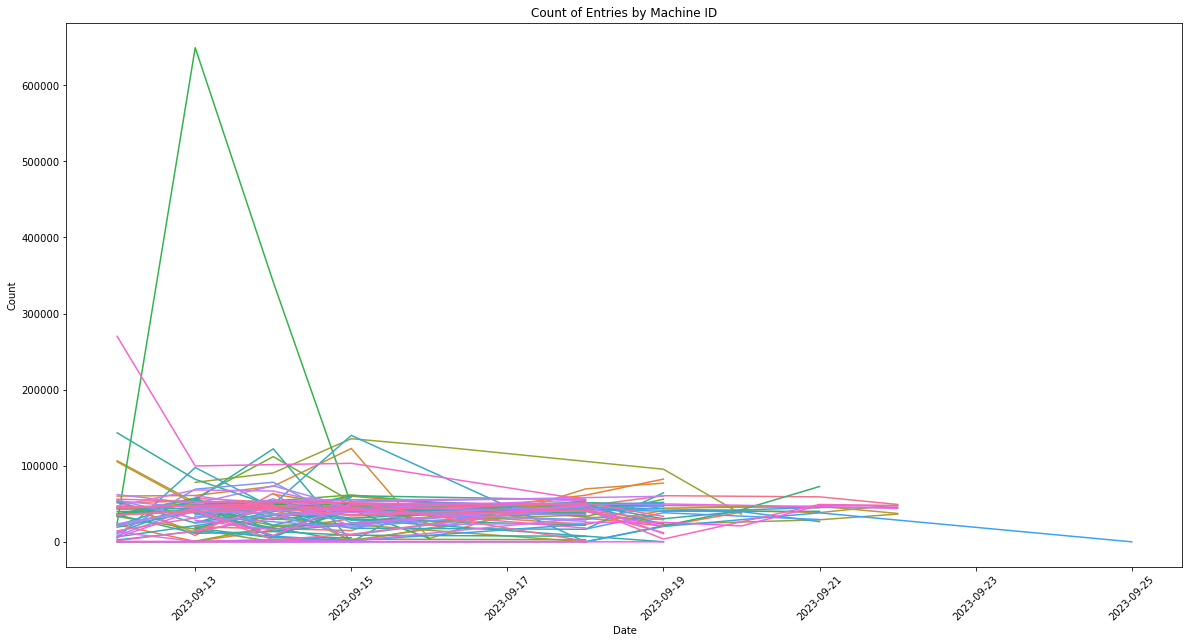

In [30]:
plt.figure(figsize=(20, 10), facecolor='white')
sns.lineplot(x='date', y='count', hue='machine_id', data=result_df)
plt.title('Count of Entries by Machine ID')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
# 라벨 제거
plt.legend().set_visible(False)
plt.show()

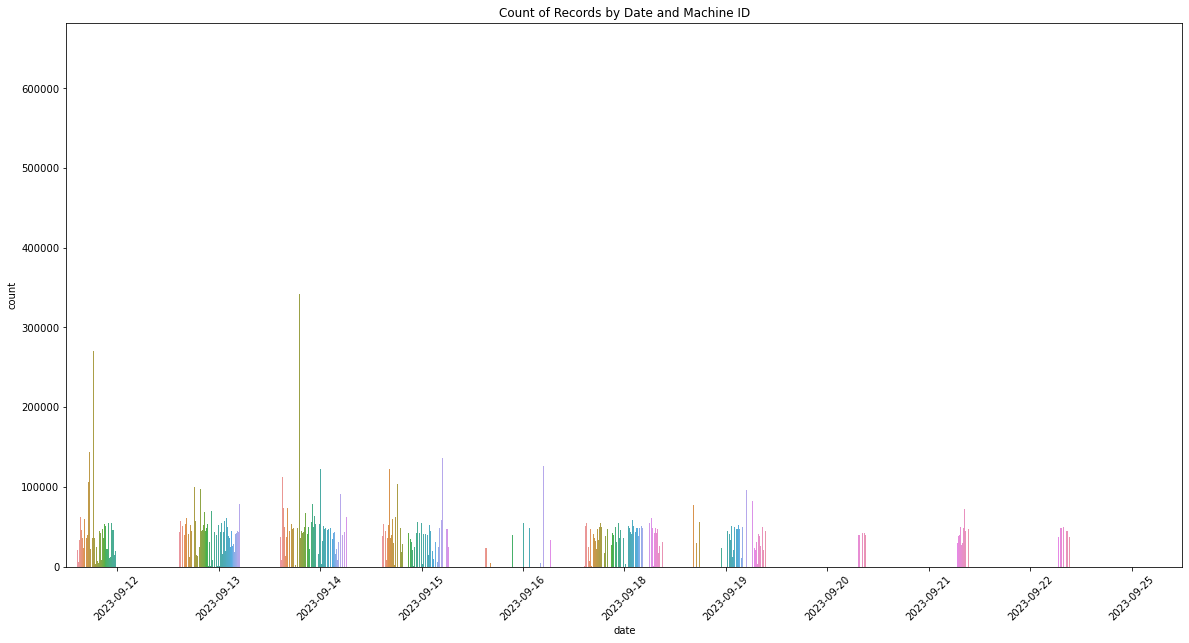

In [31]:
# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
sns.countplot(data=df, x='date', hue='machine_id')

# x축 눈금 회전
plt.xticks(rotation=45)

# 그래프 제목 설정
plt.title('Count of Records by Date and Machine ID')

# 라벨 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

<span style="font-size:28px;">**** 데이터 개수 너무 많아 중복 처리 진행***</span>

- 1차 중복 처리 진행

In [32]:
df_230912 = df[df['date']==datetime.date(2023, 9, 12)]
print('데이터 중복 처리 전 데이터 개수 확인 :', df_230912['date'].count())
df_230912 = df_230912.drop_duplicates()
print('데이터 중복 처리 후 데이터 개수 확인 :', df_230912['date'].count())
df_230912

데이터 중복 처리 전 데이터 개수 확인 : 2028729
데이터 중복 처리 후 데이터 개수 확인 : 2017563


,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
0,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:51,4095.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:51,10,5,51,Tuesday
1,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:55.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
2,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:56.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
3,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:56,804.0,2023-09-12 10:05:57.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:56,10,5,56,Tuesday
4,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:57,768.0,2023-09-12 10:05:58.000,2023-09-12 10:13:14.000,2023-09-12,2023,9,12,10:05:57,10,5,57,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799951,24:4C:AB:83:F0:7A,SmartPatch_F07A,1.0,0.0,2023-09-12 16:55:18,400.0,2023-09-12 16:55:18.000,2023-09-15 08:11:52.000,2023-09-12,2023,9,12,16:55:18,16,55,18,Tuesday
8799952,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 16:55:18,760.0,2023-09-12 16:55:19.000,2023-09-15 08:11:52.000,2023-09-12,2023,9,12,16:55:18,16,55,18,Tuesday
8799953,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 16:55:19,596.0,2023-09-12 16:55:19.000,2023-09-15 08:11:52.000,2023-09-12,2023,9,12,16:55:19,16,55,19,Tuesday
8799954,24:4C:AB:83:F0:7A,SmartPatch_F07A,1.0,0.0,2023-09-12 16:55:19,444.0,2023-09-12 16:55:20.000,2023-09-15 08:11:52.000,2023-09-12,2023,9,12,16:55:19,16,55,19,Tuesday


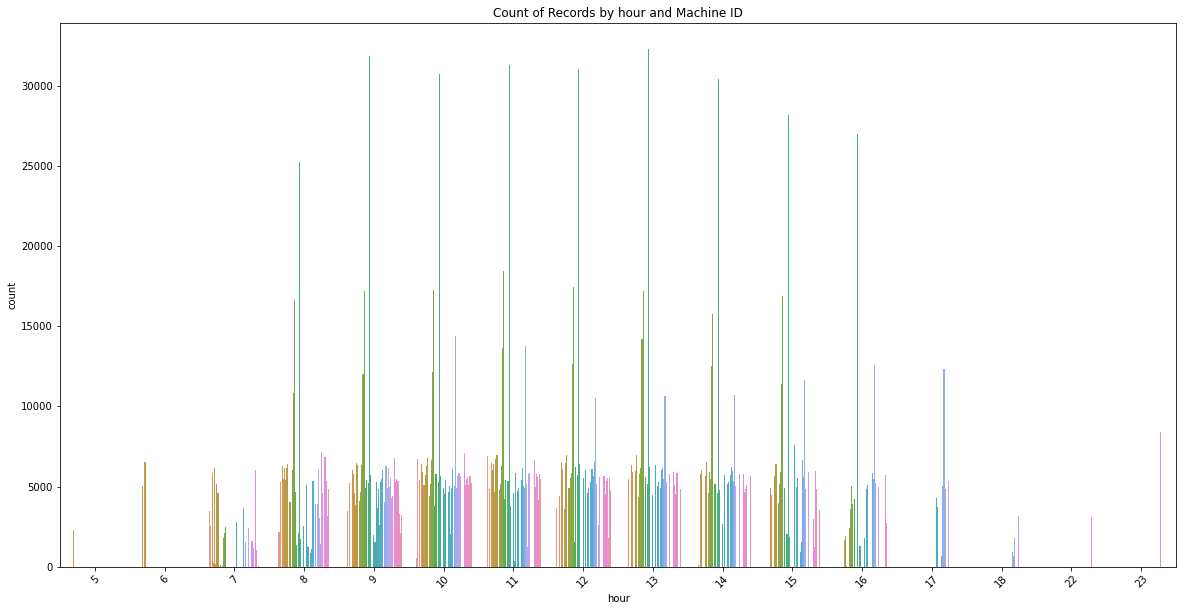

In [33]:

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
sns.countplot(data=df_230912, x='hour', hue='machine_id')

# x축 눈금 회전
plt.xticks(rotation=45)

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

In [34]:
df_230912['machine_id'].value_counts()

SmartPatch_F07A    267926
SmartPatch_9656    142793
SmartPatch_780A    106263
SmartPatch_5246    103543
SmartPatch_F006     61954
SmartPatch_522E     59889
SmartPatch_FC32     56140
SmartPatch_EFF2     54962
SmartPatch_F002     53796
SmartPatch_1D52     53685
SmartPatch_5242     52288
SmartPatch_A066     51940
SmartPatch_51E6     51052
SmartPatch_F022     47096
SmartPatch_A81E     46236
SmartPatch_FBEA     45894
SmartPatch_7A16     45457
SmartPatch_FB8E     44328
SmartPatch_7A76     43987
SmartPatch_51EE     42340
SmartPatch_9626     39792
SmartPatch_7A7E     37257
SmartPatch_9696     36159
SmartPatch_5236     36015
SmartPatch_FC1E     35428
SmartPatch_FC3A     35153
SmartPatch_9652     34920
SmartPatch_966A     33612
SmartPatch_7A6E     33329
SmartPatch_7A66     32768
SmartPatch_7AAA     24145
SmartPatch_EFFA     23440
SmartPatch_5202     22256
SmartPatch_77CA     21653
SmartPatch_A832     21504
SmartPatch_F00A     20723
SmartPatch_A07E     19162
SmartPatch_FBCE     14358
SmartPatch_F

In [35]:
df_230912_F07A = df_230912[df_230912['machine_id'] == 'SmartPatch_F07A']
df_230912_F07A

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,created_date,date,year,month,day,time,hour,minute,second,week
746422,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 08:11:22,4095.0,2023-09-12 08:11:26.000,2023-09-12 16:59:28.000,2023-09-12,2023,9,12,08:11:22,8,11,22,Tuesday
746423,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 08:11:26,4095.0,2023-09-12 08:11:30.000,2023-09-12 16:59:28.000,2023-09-12,2023,9,12,08:11:26,8,11,26,Tuesday
746424,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 08:11:30,1180.0,2023-09-12 08:11:31.000,2023-09-12 16:59:28.000,2023-09-12,2023,9,12,08:11:30,8,11,30,Tuesday
746425,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 08:11:31,4095.0,2023-09-12 08:11:35.000,2023-09-12 16:59:28.000,2023-09-12,2023,9,12,08:11:31,8,11,31,Tuesday
746426,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 08:11:35,576.0,2023-09-12 08:11:36.000,2023-09-12 16:59:28.000,2023-09-12,2023,9,12,08:11:35,8,11,35,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799951,24:4C:AB:83:F0:7A,SmartPatch_F07A,1.0,0.0,2023-09-12 16:55:18,400.0,2023-09-12 16:55:18.000,2023-09-15 08:11:52.000,2023-09-12,2023,9,12,16:55:18,16,55,18,Tuesday
8799952,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 16:55:18,760.0,2023-09-12 16:55:19.000,2023-09-15 08:11:52.000,2023-09-12,2023,9,12,16:55:18,16,55,18,Tuesday
8799953,24:4C:AB:83:F0:7A,SmartPatch_F07A,0.0,0.0,2023-09-12 16:55:19,596.0,2023-09-12 16:55:19.000,2023-09-15 08:11:52.000,2023-09-12,2023,9,12,16:55:19,16,55,19,Tuesday
8799954,24:4C:AB:83:F0:7A,SmartPatch_F07A,1.0,0.0,2023-09-12 16:55:19,444.0,2023-09-12 16:55:20.000,2023-09-15 08:11:52.000,2023-09-12,2023,9,12,16:55:19,16,55,19,Tuesday


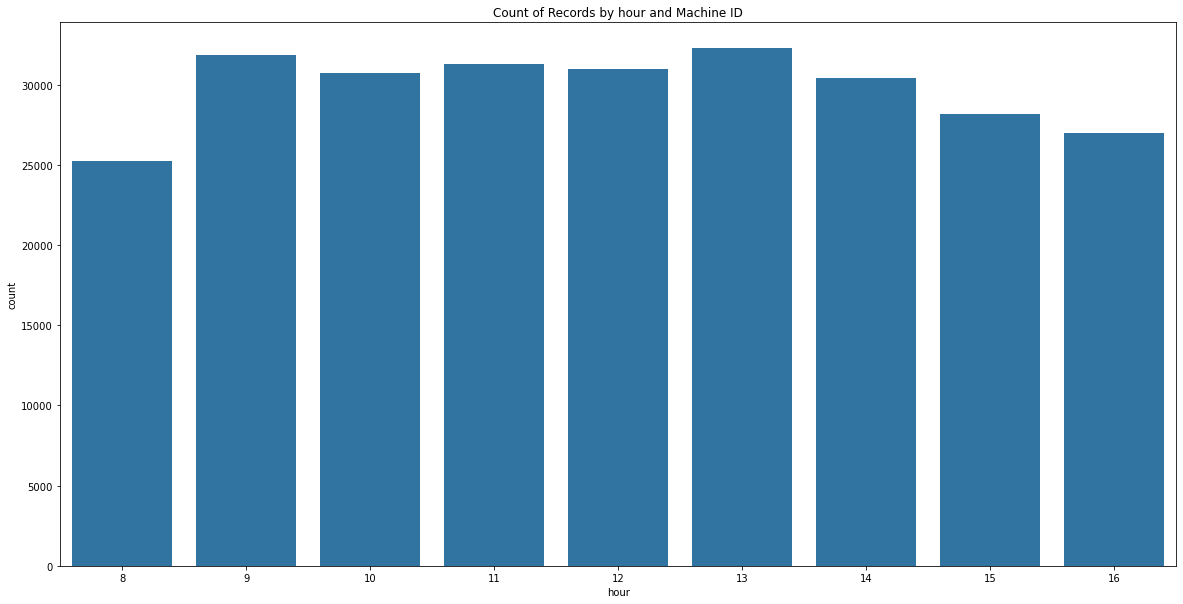

In [36]:

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
sns.countplot(data=df_230912_F07A, x='hour', hue='machine_id')

# x축 눈금 회전
# plt.xticks(rotation=45)

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

In [37]:
df_230912_F07A['start_date_time'].value_counts()

2023-09-12 08:19:47    15
2023-09-12 08:14:13    15
2023-09-12 12:53:59    15
2023-09-12 11:15:04    15
2023-09-12 10:08:47    15
                       ..
2023-09-12 14:29:35     5
2023-09-12 14:05:25     5
2023-09-12 15:39:40     5
2023-09-12 09:32:11     5
2023-09-12 08:40:36     5
Name: start_date_time, Length: 31195, dtype: int64

# 데이터 중복 처리 안되는 부분 created_date만 다른 부분 확인 후 처리

- 2차 중복 처리 진행

In [38]:
warnings.filterwarnings("ignore")
print('데이터 중복 처리 전 데이터 개수 확인 :', df_230912_F07A['date'].count())
df_230912_F07A.drop(columns=['created_date'], inplace=True)
df_230912_F07A = df_230912_F07A.drop_duplicates()
print('데이터 중복 처리 후 데이터 개수 확인 :', df_230912_F07A['date'].count())

데이터 중복 처리 전 데이터 개수 확인 : 267926
데이터 중복 처리 후 데이터 개수 확인 : 53584


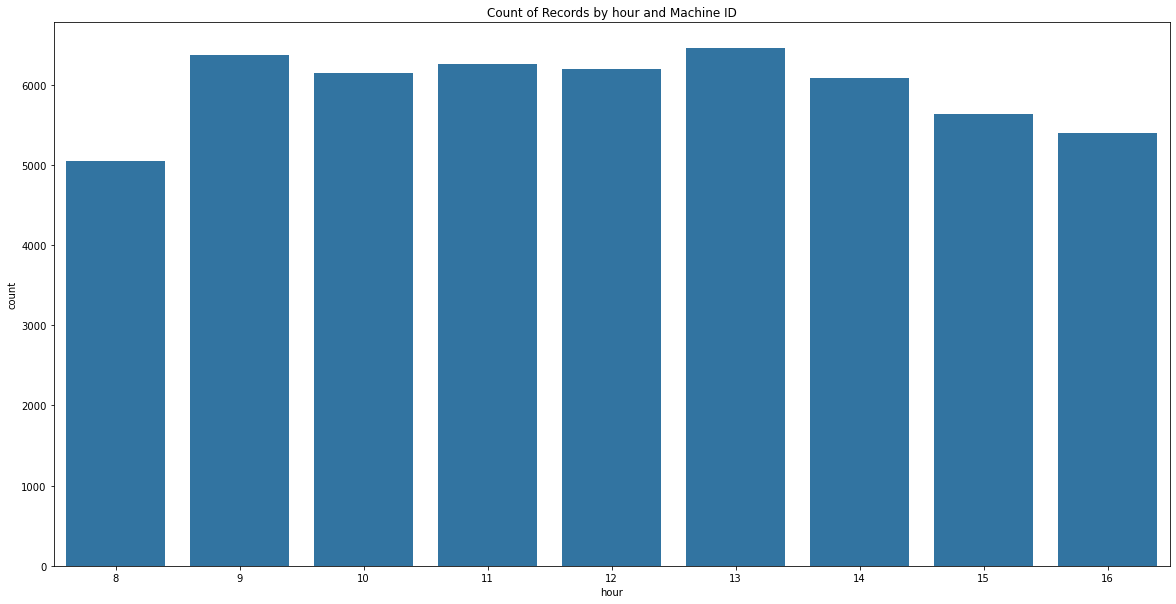

In [39]:

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
sns.countplot(data=df_230912_F07A, x='hour', hue='machine_id')

# x축 눈금 회전
# plt.xticks(rotation=45)

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

In [40]:
warnings.filterwarnings("ignore")
print('df 데이터 중복 처리 전 데이터 개수 확인 :', df['date'].count())
df.drop(columns=['created_date'], inplace=True)
df = df.drop_duplicates()
print('df 데이터 중복 처리 후 데이터 개수 확인 :', df['date'].count())

df 데이터 중복 처리 전 데이터 개수 확인 : 17021684
df 데이터 중복 처리 후 데이터 개수 확인 : 15355702


In [41]:
print('df_230912 데이터 중복 처리 전 데이터 개수 확인 :', df_230912['date'].count())
df_230912.drop(columns=['created_date'], inplace=True)
df_230912 = df_230912.drop_duplicates()
print('df_230912 데이터 중복 처리 후 데이터 개수 확인 :', df_230912['date'].count())

df_230912 데이터 중복 처리 전 데이터 개수 확인 : 2017563
df_230912 데이터 중복 처리 후 데이터 개수 확인 : 1603095


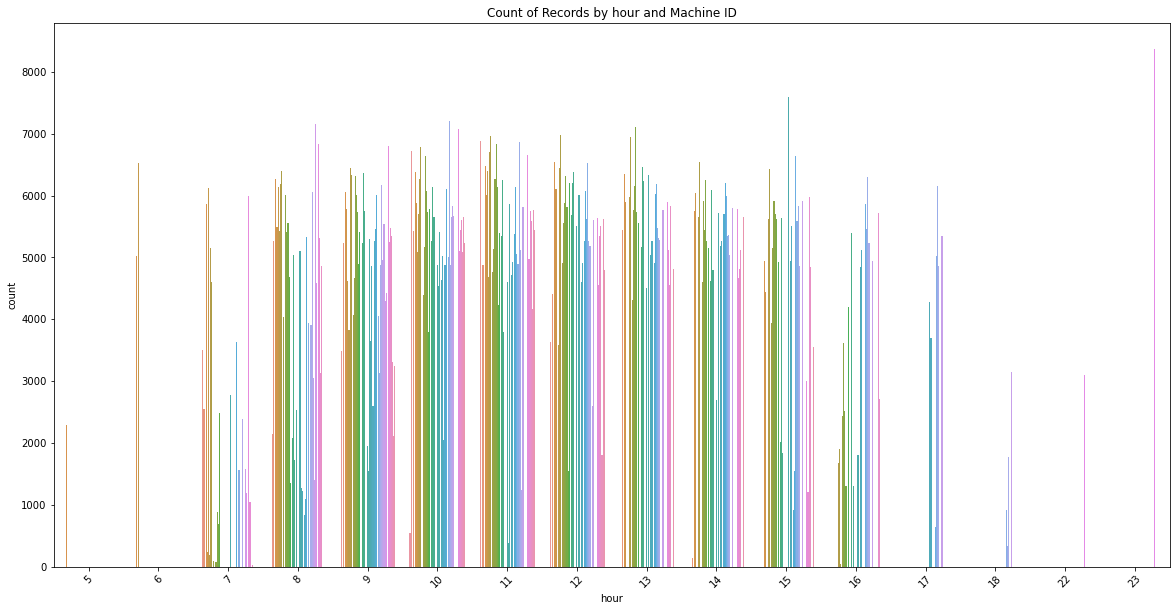

In [42]:

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
sns.countplot(data=df_230912, x='hour', hue='machine_id')

# x축 눈금 회전
plt.xticks(rotation=45)

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# 데이터 개수 확인 기준 설정
- rr인터벌 2000 이상값을 제외한 전체 평균 617 \\
- 계산을 위해 600으로 설정 \\
- rr인터벌 600을 기준으로 심박수로 변환시 1분에 60번 심박 \\
- 1분에 60번 * 1시간 60분 => 1시간 기준 데이터는 3,600개, 하루 86,400개 \\
- 근무시간 8시에서 12시, 13시에서 17시 기준으로 데이터 갯수는 1시간 3,600개 * 8시간 = 28,800개 기준으로 모니터링 실시\\
- 9월12부터 19일까지 모니터링

In [43]:
# rr_interval 값이 2000 미만인 행들을 필터링
filtered_df = df[df['rr_interval'] < 2000]

# 필터링된 행들의 'rr_interval' 열의 평균을 계산
mean_rr_interval = filtered_df['rr_interval'].mean()

print(f"The mean of rr_interval values below 2000 is: {mean_rr_interval}")

The mean of rr_interval values below 2000 is: 631.130564718446


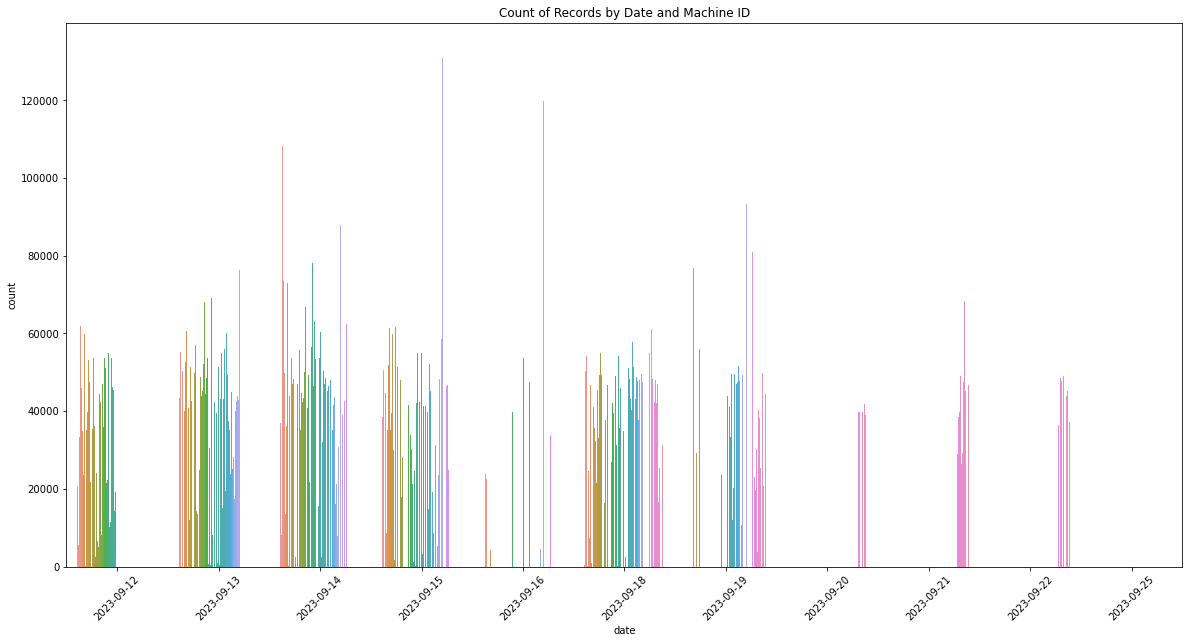

In [44]:
# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
sns.countplot(data=df, x='date', hue='machine_id')

# x축 눈금 회전
plt.xticks(rotation=45)

# 그래프 제목 설정
plt.title('Count of Records by Date and Machine ID')

# 라벨 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# 하루 단위 패치 디바이별 데이터 개수 상세 확인

9월12일 데이터 수집 진행한 패치 디바이스 개수 : 51
['SmartPatch_F03E' 'SmartPatch_F00A' 'SmartPatch_F052' 'SmartPatch_7A6E'
 'SmartPatch_F04A' 'SmartPatch_F006' 'SmartPatch_FBEA' 'SmartPatch_9652'
 'SmartPatch_EFFA' 'SmartPatch_FC32' 'SmartPatch_522E' 'SmartPatch_A856'
 'SmartPatch_FC3A' 'SmartPatch_9626' 'SmartPatch_5242' 'SmartPatch_780A'
 'SmartPatch_9656' 'SmartPatch_77CA' 'SmartPatch_7A76' 'SmartPatch_7A22'
 'SmartPatch_FC1E' 'SmartPatch_F07A' 'SmartPatch_9696' 'SmartPatch_FBCA'
 'SmartPatch_A8B6' 'SmartPatch_7AAA' 'SmartPatch_A806' 'SmartPatch_A066'
 'SmartPatch_A83E' 'SmartPatch_FB8E' 'SmartPatch_51EE' 'SmartPatch_EFE6'
 'SmartPatch_966A' 'SmartPatch_F022' 'SmartPatch_5236' 'SmartPatch_F002'
 'SmartPatch_5246' 'SmartPatch_51E6' 'SmartPatch_A832' 'SmartPatch_5202'
 'SmartPatch_EFF2' 'SmartPatch_F02A' 'SmartPatch_EFDE' 'SmartPatch_A862'
 'SmartPatch_1D52' 'SmartPatch_7A7E' 'SmartPatch_A81E' 'SmartPatch_7A16'
 'SmartPatch_FBCE' 'SmartPatch_A07E' 'SmartPatch_7A66']


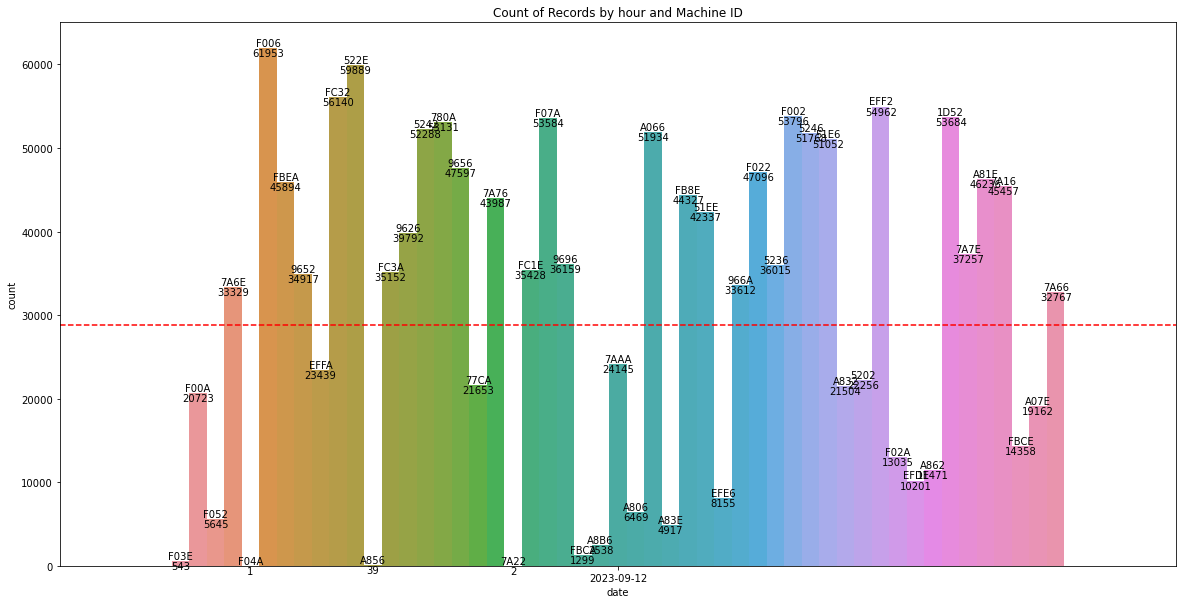

하루 수집 데이터 미달 패치 디바이스 개수 확인 : 21
['SmartPatch_7AAA', 'SmartPatch_EFFA', 'SmartPatch_5202', 'SmartPatch_77CA', 'SmartPatch_A832', 'SmartPatch_F00A', 'SmartPatch_A07E', 'SmartPatch_FBCE', 'SmartPatch_F02A', 'SmartPatch_A862', 'SmartPatch_EFDE', 'SmartPatch_EFE6', 'SmartPatch_A806', 'SmartPatch_F052', 'SmartPatch_A83E', 'SmartPatch_A8B6', 'SmartPatch_FBCA', 'SmartPatch_F03E', 'SmartPatch_A856', 'SmartPatch_7A22', 'SmartPatch_F04A']


In [45]:
df_tem = df_230912
print('9월12일 데이터 수집 진행한 패치 디바이스 개수 :', df_230912['machine_id'].nunique())
print(df_230912['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_230912, x='date', hue='machine_id')

# # x축 눈금 회전
# plt.xticks(rotation=45)

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')
#     ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', color='red')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_230912['machine_id'].unique()[i % len(df_230912['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print('하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)

In [46]:
# 패치 디바이스별 수집 시작~끝 시간 확인
time_check = df_230912.groupby('machine_id')['time'].agg(['min', 'max'])
print(time_check)

                      min       max
machine_id                         
SmartPatch_1D52  07:06:40  15:31:48
SmartPatch_51E6  08:09:34  18:21:48
SmartPatch_51EE  09:26:29  17:50:57
SmartPatch_5202  08:24:47  12:26:58
SmartPatch_522E  07:14:35  16:17:14
SmartPatch_5236  11:12:51  17:08:07
SmartPatch_5242  07:59:09  16:35:38
SmartPatch_5246  09:28:33  18:02:59
SmartPatch_77CA  07:26:25  12:25:01
SmartPatch_780A  07:49:43  16:27:12
SmartPatch_7A16  07:59:34  16:39:08
SmartPatch_7A22  16:51:53  16:51:53
SmartPatch_7A66  09:18:50  15:31:25
SmartPatch_7A6E  07:29:25  14:01:20
SmartPatch_7A76  08:46:50  16:49:20
SmartPatch_7A7E  07:48:25  15:21:15
SmartPatch_7AAA  09:28:43  14:28:08
SmartPatch_9626  09:10:43  16:30:12
SmartPatch_9652  06:02:05  11:56:33
SmartPatch_9656  07:51:55  16:17:11
SmartPatch_966A  08:47:33  15:09:00
SmartPatch_9696  08:40:23  15:15:58
SmartPatch_A066  07:25:54  16:13:09
SmartPatch_A07E  09:37:02  12:59:32
SmartPatch_A806  09:37:21  11:05:23
SmartPatch_A81E  08:25:53  1

In [47]:
df_230912[df_230912['machine_id']=='SmartPatch_1D52']

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,date,year,month,day,time,hour,minute,second,week
1496678,8C:4B:14:6C:1D:52,SmartPatch_1D52,0.0,0.0,2023-09-12 07:06:40,4095.0,2023-09-12 07:06:44.000,2023-09-12,2023,9,12,07:06:40,7,6,40,Tuesday
1496679,8C:4B:14:6C:1D:52,SmartPatch_1D52,0.0,0.0,2023-09-12 07:06:44,1672.0,2023-09-12 07:06:45.000,2023-09-12,2023,9,12,07:06:44,7,6,44,Tuesday
1496680,8C:4B:14:6C:1D:52,SmartPatch_1D52,0.0,0.0,2023-09-12 07:06:45,548.0,2023-09-12 07:06:46.000,2023-09-12,2023,9,12,07:06:45,7,6,45,Tuesday
1496681,8C:4B:14:6C:1D:52,SmartPatch_1D52,0.0,0.0,2023-09-12 07:06:46,556.0,2023-09-12 07:06:46.000,2023-09-12,2023,9,12,07:06:46,7,6,46,Tuesday
1496682,8C:4B:14:6C:1D:52,SmartPatch_1D52,0.0,0.0,2023-09-12 07:06:46,528.0,2023-09-12 07:06:47.000,2023-09-12,2023,9,12,07:06:46,7,6,46,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553693,8C:4B:14:6C:1D:52,SmartPatch_1D52,1.0,0.0,2023-09-12 15:31:45,400.0,2023-09-12 15:31:45.000,2023-09-12,2023,9,12,15:31:45,15,31,45,Tuesday
1553694,8C:4B:14:6C:1D:52,SmartPatch_1D52,0.0,0.0,2023-09-12 15:31:45,1716.0,2023-09-12 15:31:47.000,2023-09-12,2023,9,12,15:31:45,15,31,45,Tuesday
1553695,8C:4B:14:6C:1D:52,SmartPatch_1D52,1.0,0.0,2023-09-12 15:31:47,400.0,2023-09-12 15:31:47.000,2023-09-12,2023,9,12,15:31:47,15,31,47,Tuesday
1553697,8C:4B:14:6C:1D:52,SmartPatch_1D52,1.0,1.0,2023-09-12 15:31:47,400.0,2023-09-12 15:31:48.000,2023-09-12,2023,9,12,15:31:47,15,31,47,Tuesday


9월13일 데이터 수집 진행한 패치 디바이스 개수 : 74
['SmartPatch_A856' 'SmartPatch_7A4E' 'SmartPatch_F04A' 'SmartPatch_FBCE'
 'SmartPatch_F006' 'SmartPatch_F00A' 'SmartPatch_77CA' 'SmartPatch_EFFA'
 'SmartPatch_FC32' 'SmartPatch_1D52' 'SmartPatch_780A' 'SmartPatch_F026'
 'SmartPatch_7A22' 'SmartPatch_522E' 'SmartPatch_9656' 'SmartPatch_F052'
 'SmartPatch_9626' 'SmartPatch_9EE2' 'SmartPatch_5242' 'SmartPatch_A8B6'
 'SmartPatch_7A52' 'SmartPatch_EFF2' 'SmartPatch_EFE6' 'SmartPatch_F002'
 'SmartPatch_FB8E' 'SmartPatch_A832' 'SmartPatch_A826' 'SmartPatch_5202'
 'SmartPatch_9696' 'SmartPatch_A012' 'SmartPatch_5226' 'SmartPatch_FC2E'
 'SmartPatch_7AA6' 'SmartPatch_240E' 'SmartPatch_51E2' 'SmartPatch_F03A'
 'SmartPatch_966A' 'SmartPatch_F016' 'SmartPatch_965E' 'SmartPatch_5236'
 'SmartPatch_779A' 'SmartPatch_B07E' 'SmartPatch_9652' 'SmartPatch_51EE'
 'SmartPatch_C06E' 'SmartPatch_EFE2' 'SmartPatch_A862' 'SmartPatch_A86A'
 'SmartPatch_A072' 'SmartPatch_9632' 'SmartPatch_A83E' 'SmartPatch_F022'
 'SmartPatch_F02A'

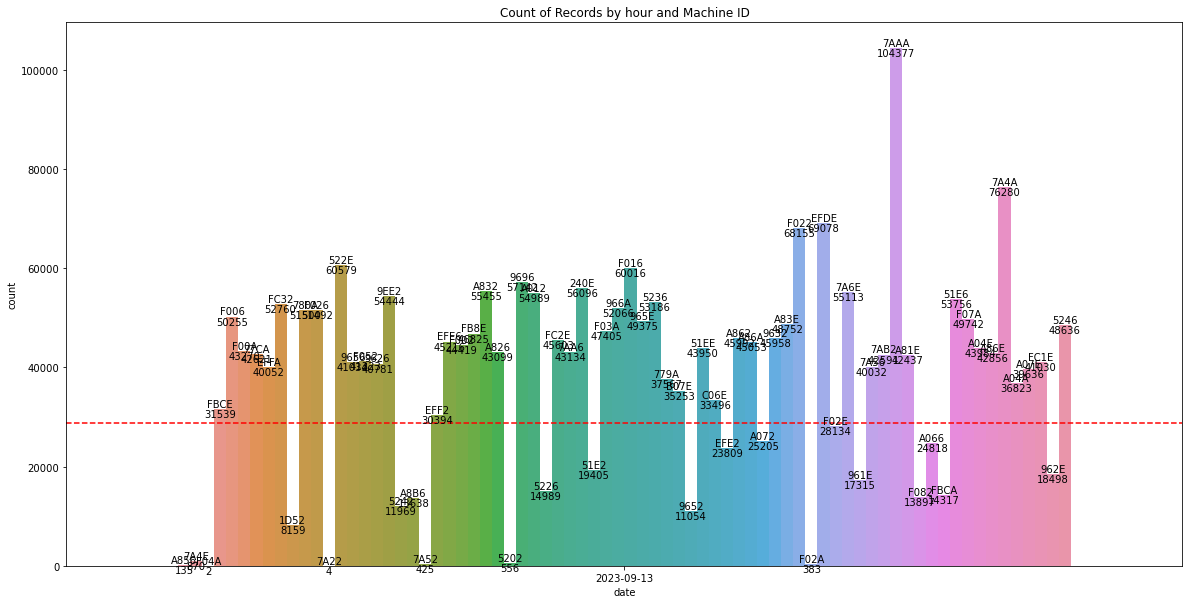

9월13일 하루 수집 데이터 미달 패치 디바이스 개수 확인 : 21
['SmartPatch_F02E', 'SmartPatch_A072', 'SmartPatch_A066', 'SmartPatch_EFE2', 'SmartPatch_51E2', 'SmartPatch_962E', 'SmartPatch_961E', 'SmartPatch_5226', 'SmartPatch_FBCA', 'SmartPatch_F082', 'SmartPatch_A8B6', 'SmartPatch_5242', 'SmartPatch_9652', 'SmartPatch_1D52', 'SmartPatch_7A4E', 'SmartPatch_5202', 'SmartPatch_7A52', 'SmartPatch_F02A', 'SmartPatch_A856', 'SmartPatch_7A22', 'SmartPatch_F04A']


In [48]:
df_230913 = df[df['date']==datetime.date(2023, 9, 13)]
df_tem = df_230913
df_tem_date = '9월13일'

print(df_tem_date, '데이터 수집 진행한 패치 디바이스 개수 :', df_tem['machine_id'].nunique())
print(df_tem['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_tem, x='date', hue='machine_id')

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_tem['machine_id'].unique()[i % len(df_tem['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print(df_tem_date, '하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)


In [49]:
# 패치 디바이스별 하루 수집 시작~끝 시간 확인
df_tem_time_check = df_tem.groupby('machine_id')['time'].agg(['min', 'max'])
print(df_tem_date, '패치 디바이스별 수집 시작 ~ 끝 시간 확인')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_tem_time_check)

9월13일 패치 디바이스별 수집 시작 ~ 끝 시간 확인
                      min       max
machine_id                         
SmartPatch_1D52  07:00:38  17:52:49
SmartPatch_240E  07:39:38  17:01:50
SmartPatch_51E2  08:03:01  13:16:58
SmartPatch_51E6  07:47:06  18:00:11
SmartPatch_51EE  08:11:04  18:05:44
SmartPatch_5202  17:29:11  17:33:43
SmartPatch_5226  08:57:03  12:26:41
SmartPatch_522E  07:48:15  21:56:50
SmartPatch_5236  09:02:26  18:02:05
SmartPatch_5242  07:45:05  09:44:17
SmartPatch_5246  09:13:40  18:00:41
SmartPatch_779A  07:29:05  14:48:50
SmartPatch_77CA  07:31:07  15:13:26
SmartPatch_780A  07:43:50  16:10:35
SmartPatch_7A22  16:32:41  16:32:42
SmartPatch_7A4A  10:25:14  23:43:45
SmartPatch_7A4E  09:21:20  09:28:20
SmartPatch_7A52  16:45:20  16:48:44
SmartPatch_7A56  09:23:06  17:23:14
SmartPatch_7A6E  13:04:22  22:00:41
SmartPatch_7AA6  07:49:07  17:29:52
SmartPatch_7AAA  09:18:56  23:59:59
SmartPatch_7AB2  06:50:31  14:24:26
SmartPatch_961E  06:03:12  08:22:55
SmartPatch_9626  09:24:47  16:44:

In [50]:
# 데이터 하루 전체 기준으로 보면 86,400개인데 심박수가 조금 빨리 뛰고 하루 종일 착용시 10,000개 넘어갈 수 있음
df_tem[df_tem['machine_id'].str[-4:] == '7AAA']

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,date,year,month,day,time,hour,minute,second,week
4342505,24:4C:AB:82:7A:AA,SmartPatch_7AAA,1.0,0.0,2023-09-13 09:18:56,434.0,2023-09-13 09:18:56.000,2023-09-13,2023,9,13,09:18:56,9,18,56,Wednesday
4342506,24:4C:AB:82:7A:AA,SmartPatch_7AAA,1.0,1.0,2023-09-13 09:18:56,400.0,2023-09-13 09:18:56.000,2023-09-13,2023,9,13,09:18:56,9,18,56,Wednesday
4342507,24:4C:AB:82:7A:AA,SmartPatch_7AAA,0.0,0.0,2023-09-13 09:18:56,4095.0,2023-09-13 09:19:00.000,2023-09-13,2023,9,13,09:18:56,9,18,56,Wednesday
4342508,24:4C:AB:82:7A:AA,SmartPatch_7AAA,0.0,0.0,2023-09-13 09:19:00,1100.0,2023-09-13 09:19:02.000,2023-09-13,2023,9,13,09:19:00,9,19,0,Wednesday
4342509,24:4C:AB:82:7A:AA,SmartPatch_7AAA,1.0,0.0,2023-09-13 09:19:02,472.0,2023-09-13 09:19:02.000,2023-09-13,2023,9,13,09:19:02,9,19,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450755,24:4C:AB:82:7A:AA,SmartPatch_7AAA,1.0,0.0,2023-09-13 23:59:57,400.0,2023-09-13 23:59:58.000,2023-09-13,2023,9,13,23:59:57,23,59,57,Wednesday
4450756,24:4C:AB:82:7A:AA,SmartPatch_7AAA,1.0,0.0,2023-09-13 23:59:58,400.0,2023-09-13 23:59:58.000,2023-09-13,2023,9,13,23:59:58,23,59,58,Wednesday
4450757,24:4C:AB:82:7A:AA,SmartPatch_7AAA,1.0,1.0,2023-09-13 23:59:58,400.0,2023-09-13 23:59:59.000,2023-09-13,2023,9,13,23:59:58,23,59,58,Wednesday
4450758,24:4C:AB:82:7A:AA,SmartPatch_7AAA,0.0,0.0,2023-09-13 23:59:59,531.0,2023-09-13 23:59:59.000,2023-09-13,2023,9,13,23:59:59,23,59,59,Wednesday


9월14일 데이터 수집 진행한 패치 디바이스 개수 : 69
['SmartPatch_A856' 'SmartPatch_7AAA' 'SmartPatch_51EE' 'SmartPatch_F02E'
 'SmartPatch_7A6A' 'SmartPatch_F00A' 'SmartPatch_7A36' 'SmartPatch_EFFA'
 'SmartPatch_7A7E' 'SmartPatch_FC32' 'SmartPatch_F052' 'SmartPatch_F002'
 'SmartPatch_FC3A' 'SmartPatch_522E' 'SmartPatch_780A' 'SmartPatch_7A76'
 'SmartPatch_F026' 'SmartPatch_9EE2' 'SmartPatch_FC1E' 'SmartPatch_7A52'
 'SmartPatch_77CA' 'SmartPatch_9696' 'SmartPatch_9656' 'SmartPatch_FB8E'
 'SmartPatch_9626' 'SmartPatch_FBEA' 'SmartPatch_A826' 'SmartPatch_EFE6'
 'SmartPatch_FC2E' 'SmartPatch_240E' 'SmartPatch_9632' 'SmartPatch_7AA6'
 'SmartPatch_A83E' 'SmartPatch_9652' 'SmartPatch_EFF2' 'SmartPatch_F006'
 'SmartPatch_FBCA' 'SmartPatch_5226' 'SmartPatch_A806' 'SmartPatch_7A2A'
 'SmartPatch_F03A' 'SmartPatch_B07E' 'SmartPatch_1D52' 'SmartPatch_A832'
 'SmartPatch_A066' 'SmartPatch_965E' 'SmartPatch_966A' 'SmartPatch_A012'
 'SmartPatch_A072' 'SmartPatch_A86A' 'SmartPatch_F022' 'SmartPatch_F02A'
 'SmartPatch_EFDE'

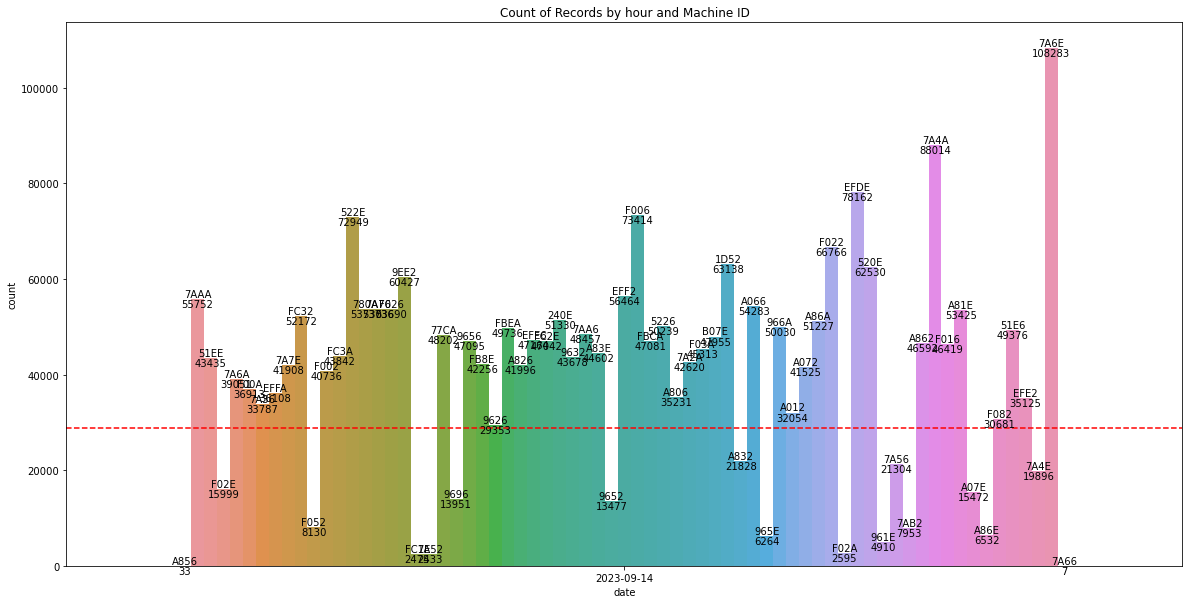

9월14일 하루 수집 데이터 미달 패치 디바이스 개수 확인 : 17
['SmartPatch_A832', 'SmartPatch_7A56', 'SmartPatch_7A4E', 'SmartPatch_F02E', 'SmartPatch_A07E', 'SmartPatch_9696', 'SmartPatch_9652', 'SmartPatch_F052', 'SmartPatch_7AB2', 'SmartPatch_A86E', 'SmartPatch_965E', 'SmartPatch_961E', 'SmartPatch_F02A', 'SmartPatch_FC1E', 'SmartPatch_7A52', 'SmartPatch_A856', 'SmartPatch_7A66']


In [51]:
df_230914 = df[df['date']==datetime.date(2023, 9, 14)]
df_tem = df_230914
df_tem_date = '9월14일'

print(df_tem_date, '데이터 수집 진행한 패치 디바이스 개수 :', df_tem['machine_id'].nunique())
print(df_tem['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_tem, x='date', hue='machine_id')

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_tem['machine_id'].unique()[i % len(df_tem['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print(df_tem_date, '하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)

9월15일 데이터 수집 진행한 패치 디바이스 개수 : 61
['SmartPatch_A862' 'SmartPatch_7A4A' 'SmartPatch_A856' 'SmartPatch_A04A'
 'SmartPatch_51FA' 'SmartPatch_9656' 'SmartPatch_FC3A' 'SmartPatch_F006'
 'SmartPatch_1D52' 'SmartPatch_9EE2' 'SmartPatch_EFFA' 'SmartPatch_F00A'
 'SmartPatch_7A7E' 'SmartPatch_F002' 'SmartPatch_A8B6' 'SmartPatch_A832'
 'SmartPatch_F026' 'SmartPatch_FC32' 'SmartPatch_F022' 'SmartPatch_9652'
 'SmartPatch_51E6' 'SmartPatch_77CA' 'SmartPatch_F052' 'SmartPatch_9626'
 'SmartPatch_A806' 'SmartPatch_7A52' 'SmartPatch_F07A' 'SmartPatch_EFF2'
 'SmartPatch_FB8E' 'SmartPatch_7AB2' 'SmartPatch_5242' 'SmartPatch_240E'
 'SmartPatch_FC2E' 'SmartPatch_A826' 'SmartPatch_51E2' 'SmartPatch_9632'
 'SmartPatch_965E' 'SmartPatch_F02A' 'SmartPatch_B07E' 'SmartPatch_F03A'
 'SmartPatch_A072' 'SmartPatch_C06E' 'SmartPatch_7A56' 'SmartPatch_7A76'
 'SmartPatch_7A2A' 'SmartPatch_5202' 'SmartPatch_962E' 'SmartPatch_A066'
 'SmartPatch_520E' 'SmartPatch_522E' 'SmartPatch_FC1E' 'SmartPatch_EFDE'
 'SmartPatch_961E'

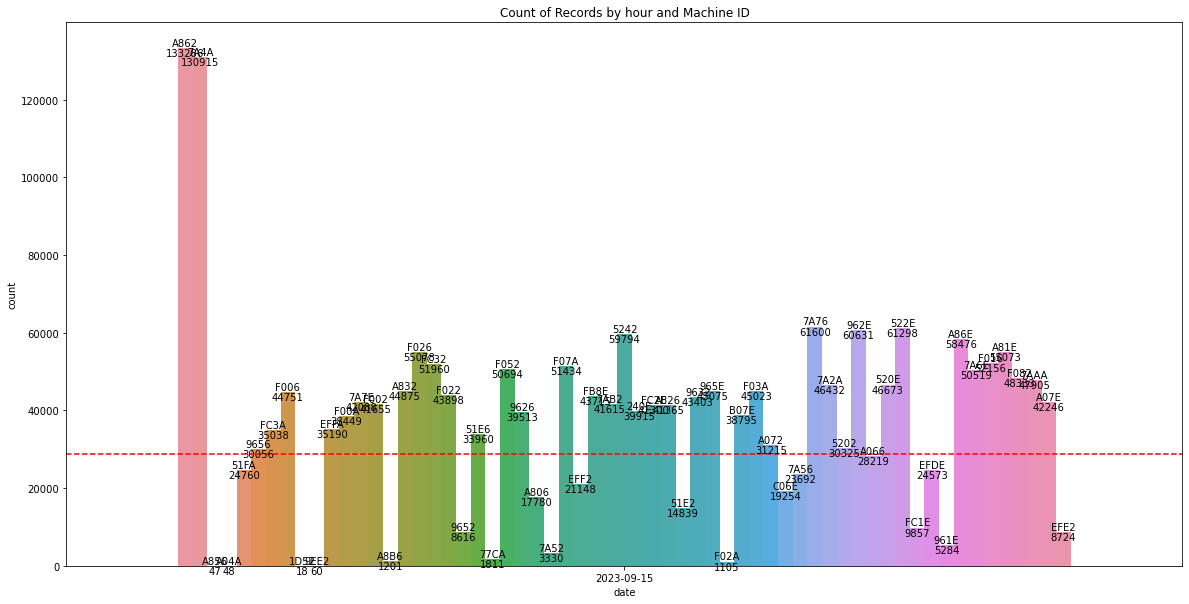

9월15일 하루 수집 데이터 미달 패치 디바이스 개수 확인 : 20
['SmartPatch_A066', 'SmartPatch_51FA', 'SmartPatch_EFDE', 'SmartPatch_7A56', 'SmartPatch_EFF2', 'SmartPatch_C06E', 'SmartPatch_A806', 'SmartPatch_51E2', 'SmartPatch_FC1E', 'SmartPatch_EFE2', 'SmartPatch_9652', 'SmartPatch_961E', 'SmartPatch_7A52', 'SmartPatch_77CA', 'SmartPatch_A8B6', 'SmartPatch_F02A', 'SmartPatch_9EE2', 'SmartPatch_A04A', 'SmartPatch_A856', 'SmartPatch_1D52']


In [52]:
df_230915 = df[df['date']==datetime.date(2023, 9, 15)]
df_tem = df_230915
df_tem_date = '9월15일'

print(df_tem_date, '데이터 수집 진행한 패치 디바이스 개수 :', df_tem['machine_id'].nunique())
print(df_tem['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_tem, x='date', hue='machine_id')

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_tem['machine_id'].unique()[i % len(df_tem['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print(df_tem_date, '하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)

9월18일 데이터 수집 진행한 패치 디바이스 개수 : 75
['SmartPatch_A856' 'SmartPatch_7A3A' 'SmartPatch_F03E' 'SmartPatch_FB8E'
 'SmartPatch_F04A' 'SmartPatch_7A7E' 'SmartPatch_7A4E' 'SmartPatch_77CA'
 'SmartPatch_F00A' 'SmartPatch_EFFA' 'SmartPatch_7A9E' 'SmartPatch_A832'
 'SmartPatch_F052' 'SmartPatch_1D52' 'SmartPatch_51E6' 'SmartPatch_FC3A'
 'SmartPatch_A066' 'SmartPatch_A806' 'SmartPatch_9626' 'SmartPatch_FC1E'
 'SmartPatch_FC32' 'SmartPatch_F026' 'SmartPatch_780A' 'SmartPatch_9656'
 'SmartPatch_7A16' 'SmartPatch_5242' 'SmartPatch_7A76' 'SmartPatch_522E'
 'SmartPatch_B056' 'SmartPatch_9696' 'SmartPatch_EFF2' 'SmartPatch_F07A'
 'SmartPatch_7A52' 'SmartPatch_F006' 'SmartPatch_240E' 'SmartPatch_77C2'
 'SmartPatch_9636' 'SmartPatch_FB9A' 'SmartPatch_FC2E' 'SmartPatch_B01A'
 'SmartPatch_0136' 'SmartPatch_F02E' 'SmartPatch_51E2' 'SmartPatch_9632'
 'SmartPatch_F022' 'SmartPatch_7A2A' 'SmartPatch_B05E' 'SmartPatch_F03A'
 'SmartPatch_965E' 'SmartPatch_B07E' 'SmartPatch_C06E' 'SmartPatch_9652'
 'SmartPatch_A8B6'

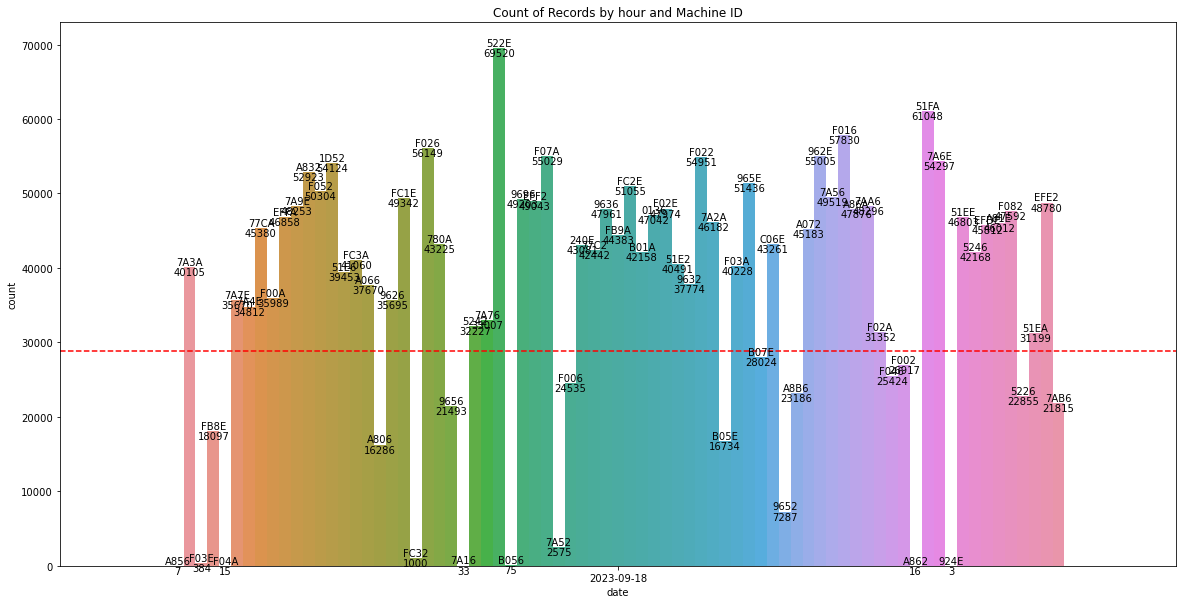

9월18일 하루 수집 데이터 미달 패치 디바이스 개수 확인 : 21
['SmartPatch_B07E', 'SmartPatch_F002', 'SmartPatch_F046', 'SmartPatch_F006', 'SmartPatch_A8B6', 'SmartPatch_5226', 'SmartPatch_7AB6', 'SmartPatch_9656', 'SmartPatch_FB8E', 'SmartPatch_B05E', 'SmartPatch_A806', 'SmartPatch_9652', 'SmartPatch_7A52', 'SmartPatch_FC32', 'SmartPatch_F03E', 'SmartPatch_B056', 'SmartPatch_7A16', 'SmartPatch_A862', 'SmartPatch_F04A', 'SmartPatch_A856', 'SmartPatch_924E']


In [53]:
df_230918 = df[df['date']==datetime.date(2023, 9, 18)]
df_tem = df_230918
df_tem_date = '9월18일'

print(df_tem_date, '데이터 수집 진행한 패치 디바이스 개수 :', df_tem['machine_id'].nunique())
print(df_tem['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_tem, x='date', hue='machine_id')

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_tem['machine_id'].unique()[i % len(df_tem['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print(df_tem_date, '하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)

9월19일 데이터 수집 진행한 패치 디바이스 개수 : 40
['SmartPatch_F032' 'SmartPatch_A8AE' 'SmartPatch_B05E' 'SmartPatch_B056'
 'SmartPatch_51EA' 'SmartPatch_FC3A' 'SmartPatch_5242' 'SmartPatch_FC2E'
 'SmartPatch_51E2' 'SmartPatch_522E' 'SmartPatch_240E' 'SmartPatch_A826'
 'SmartPatch_EFF2' 'SmartPatch_7A76' 'SmartPatch_77C2' 'SmartPatch_B01A'
 'SmartPatch_77B6' 'SmartPatch_C06E' 'SmartPatch_9636' 'SmartPatch_5226'
 'SmartPatch_7A3A' 'SmartPatch_B07E' 'SmartPatch_A86A' 'SmartPatch_A072'
 'SmartPatch_965E' 'SmartPatch_7AA6' 'SmartPatch_F016' 'SmartPatch_F02E'
 'SmartPatch_7A0E' 'SmartPatch_F046' 'SmartPatch_F03A' 'SmartPatch_7A56'
 'SmartPatch_FB9A' 'SmartPatch_0136' 'SmartPatch_F04A' 'SmartPatch_A806'
 'SmartPatch_51FA' 'SmartPatch_7A4A' 'SmartPatch_A04E' 'SmartPatch_A81E']


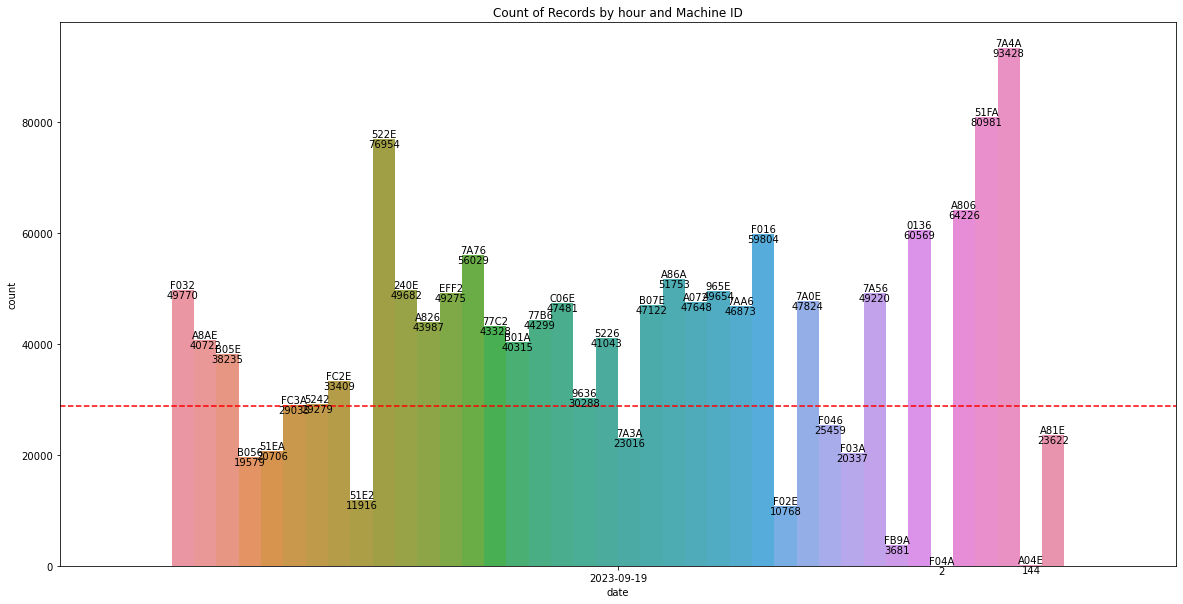

9월19일 하루 수집 데이터 미달 패치 디바이스 개수 확인 : 11
['SmartPatch_F046', 'SmartPatch_A81E', 'SmartPatch_7A3A', 'SmartPatch_51EA', 'SmartPatch_F03A', 'SmartPatch_B056', 'SmartPatch_51E2', 'SmartPatch_F02E', 'SmartPatch_FB9A', 'SmartPatch_A04E', 'SmartPatch_F04A']


In [54]:
df_230919 = df[df['date']==datetime.date(2023, 9, 19)]
df_tem = df_230919
df_tem_date = '9월19일'

print(df_tem_date, '데이터 수집 진행한 패치 디바이스 개수 :', df_tem['machine_id'].nunique())
print(df_tem['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_tem, x='date', hue='machine_id')

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_tem['machine_id'].unique()[i % len(df_tem['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print(df_tem_date, '하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)

9월20일 데이터 수집 진행한 패치 디바이스 개수 : 7
['SmartPatch_7A4A' 'SmartPatch_9636' 'SmartPatch_51EA' 'SmartPatch_F046'
 'SmartPatch_B01A' 'SmartPatch_A8AE' 'SmartPatch_924E']


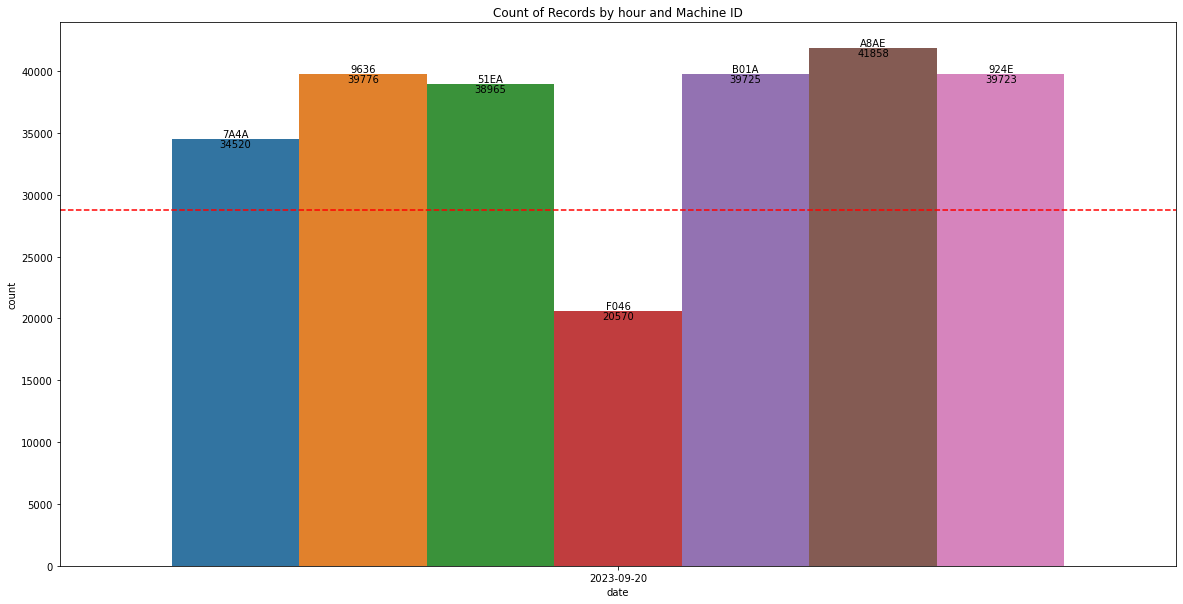

9월20일 하루 수집 데이터 미달 패치 디바이스 개수 확인 : 1
['SmartPatch_F046']


In [55]:
df_230920 = df[df['date']==datetime.date(2023, 9, 20)]
df_tem = df_230920
df_tem_date = '9월20일'

print(df_tem_date, '데이터 수집 진행한 패치 디바이스 개수 :', df_tem['machine_id'].nunique())
print(df_tem['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_tem, x='date', hue='machine_id')

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_tem['machine_id'].unique()[i % len(df_tem['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print(df_tem_date, '하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)

9월21일 데이터 수집 진행한 패치 디바이스 개수 : 14
['SmartPatch_B056' 'SmartPatch_B01A' 'SmartPatch_77C2' 'SmartPatch_9636'
 'SmartPatch_F032' 'SmartPatch_77B6' 'SmartPatch_FB9A' 'SmartPatch_7A3A'
 'SmartPatch_7A0E' 'SmartPatch_F046' 'SmartPatch_0136' 'SmartPatch_924E'
 'SmartPatch_A8AE' 'SmartPatch_B05E']


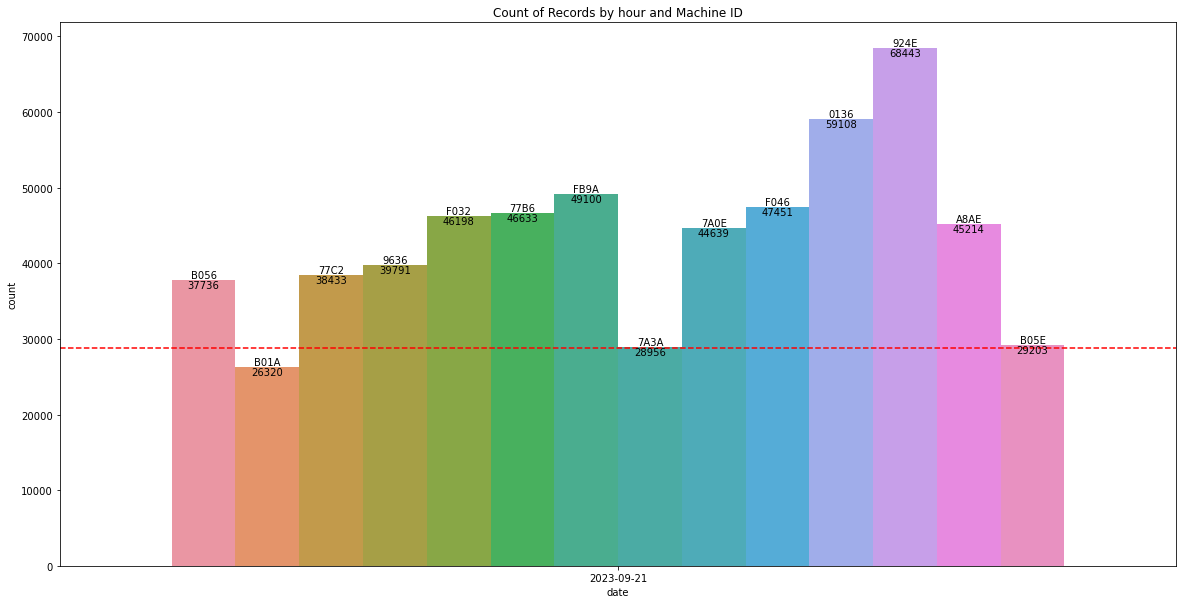

9월21일 하루 수집 데이터 미달 패치 디바이스 개수 확인 : 1
['SmartPatch_B01A']


In [56]:
df_230921 = df[df['date']==datetime.date(2023, 9, 21)]
df_tem = df_230921
df_tem_date = '9월21일'

print(df_tem_date, '데이터 수집 진행한 패치 디바이스 개수 :', df_tem['machine_id'].nunique())
print(df_tem['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_tem, x='date', hue='machine_id')

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_tem['machine_id'].unique()[i % len(df_tem['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print(df_tem_date, '하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)

9월22일 데이터 수집 진행한 패치 디바이스 개수 : 8
['SmartPatch_77B6' 'SmartPatch_F032' 'SmartPatch_0136' 'SmartPatch_FB9A'
 'SmartPatch_7A3A' 'SmartPatch_77C2' 'SmartPatch_F046' 'SmartPatch_A8AE']


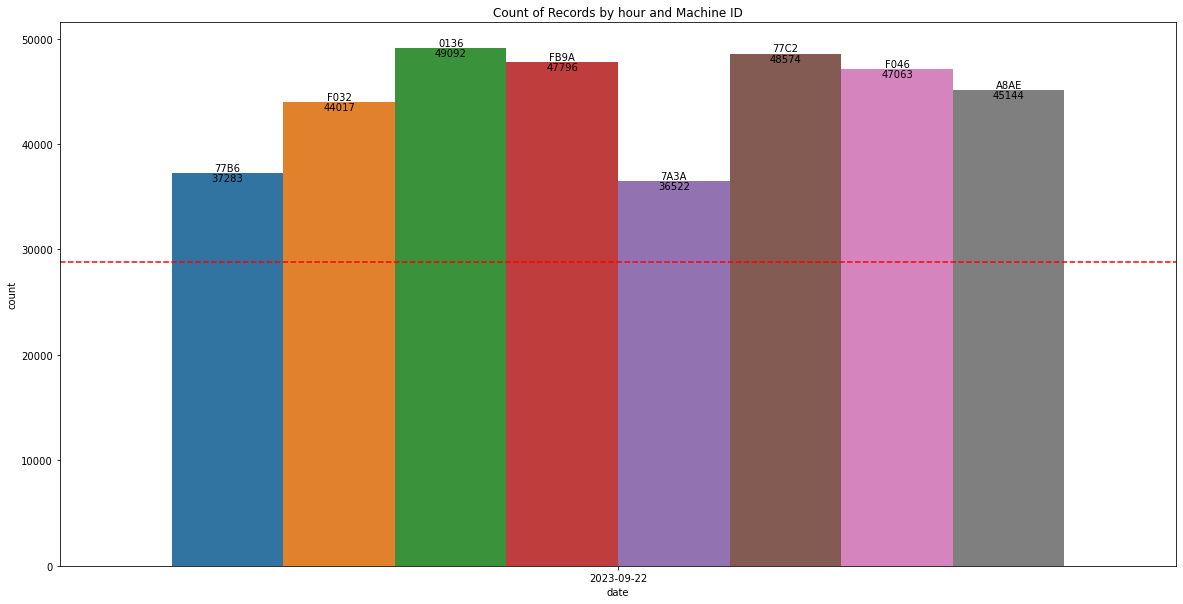

9월22일 하루 수집 데이터 미달 패치 디바이스 개수 확인 : 0
[]


In [57]:
df_230922 = df[df['date']==datetime.date(2023, 9, 22)]
df_tem = df_230922
df_tem_date = '9월22일'

print(df_tem_date, '데이터 수집 진행한 패치 디바이스 개수 :', df_tem['machine_id'].nunique())
print(df_tem['machine_id'].unique())

# 그래프 크기 설정
plt.figure(figsize=(20, 10), facecolor='white')

# Seaborn을 사용하여 그래프 그리기
ax = sns.countplot(data=df_tem, x='date', hue='machine_id')

# 그래프 제목 설정
plt.title('Count of Records by hour and Machine ID')

# 라벨 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='top')

# machine_id 라벨 추가 (위로 조금 이동)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(df_tem['machine_id'].unique()[i % len(df_tem['machine_id'].unique())][-4:], 
                (p.get_x() + p.get_width() / 2., height + 10), ha='center', va='bottom')

# 하루 데이터 기준(60개 * 60분* 8시간 = 28,800)점선 추가
ax.axhline(y=28800, color='r', linestyle='--')

# 범례 제거
plt.legend().set_visible(False)

# 그래프 표시
plt.show()

# count가 28800 미만인 machine_id 찾기
df_tem_check = df_tem['machine_id'].value_counts()[df_tem['machine_id'].value_counts() < 28800].index.tolist()

# low_count_machine_ids 리스트 출력
print(df_tem_date, '하루 수집 데이터 미달 패치 디바이스 개수 확인 :', len(df_tem_check))

# 리스트의 개수 출력
print(df_tem_check)

# rr 데이터 값 분류

In [58]:
df

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,date,year,month,day,time,hour,minute,second,week
0,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:51,4095.0,2023-09-12 10:05:55.000,2023-09-12,2023,9,12,10:05:51,10,5,51,Tuesday
1,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:55.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
2,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:56.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday
3,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:56,804.0,2023-09-12 10:05:57.000,2023-09-12,2023,9,12,10:05:56,10,5,56,Tuesday
4,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:57,768.0,2023-09-12 10:05:58.000,2023-09-12,2023,9,12,10:05:57,10,5,57,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393584,8C:CE:4E:BB:B0:56,SmartPatch_B056,1.0,1.0,2023-09-25 08:07:49,432.0,2023-09-25 08:07:49.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393586,8C:CE:4E:BB:B0:56,SmartPatch_B056,0.0,0.0,2023-09-25 08:07:49,1545.0,2023-09-25 08:07:51.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday
18393587,8C:CE:4E:BB:B0:56,SmartPatch_B056,1.0,0.0,2023-09-25 08:07:51,400.0,2023-09-25 08:07:51.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday
18393588,8C:CE:4E:BB:B0:56,SmartPatch_B056,0.0,0.0,2023-09-25 08:07:51,2160.0,2023-09-25 08:07:53.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday


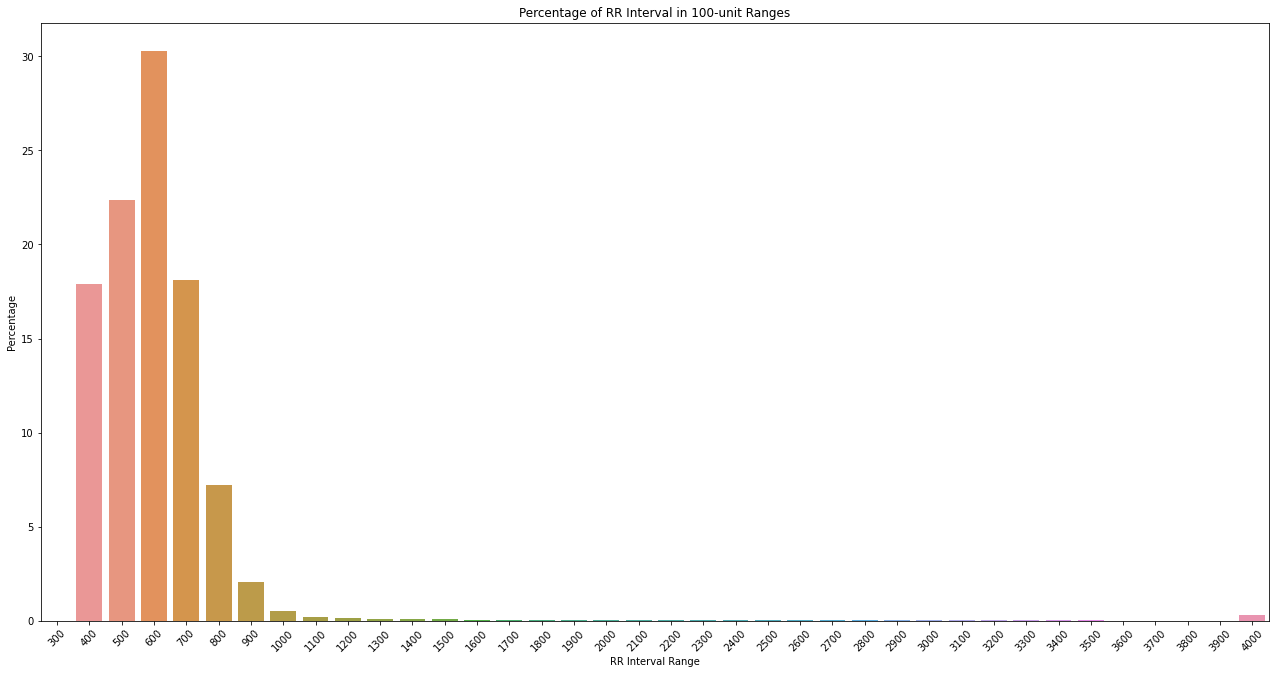

In [59]:
# 100 단위로 나눈 범위 계산
df['rr_interval_range'] = (df['rr_interval'] // 100) * 100

# rr_interval_range 칼럼의 값을 정수형으로 변환하여 소수점 제거
df['rr_interval_range'] = df['rr_interval_range'].astype(int)

# 각 범위의 비중 계산
df_percentage_per_range = (df['rr_interval_range'].value_counts() / len(df)) * 100

# 시각화
plt.figure(figsize=(22, 11),facecolor='white')
sns.barplot(x=df_percentage_per_range.index, y=df_percentage_per_range.values)
plt.xlabel('RR Interval Range')
plt.ylabel('Percentage')
plt.title('Percentage of RR Interval in 100-unit Ranges')

# x축 눈금 회전
plt.xticks(rotation=45)

plt.show()

In [60]:
df['m_id'] = df['machine_id'].str[-4:]
df

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,date,year,month,day,time,hour,minute,second,week,rr_interval_range,m_id
0,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:51,4095.0,2023-09-12 10:05:55.000,2023-09-12,2023,9,12,10:05:51,10,5,51,Tuesday,4000,F03E
1,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:55.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday,800,F03E
2,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:55,812.0,2023-09-12 10:05:56.000,2023-09-12,2023,9,12,10:05:55,10,5,55,Tuesday,800,F03E
3,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:56,804.0,2023-09-12 10:05:57.000,2023-09-12,2023,9,12,10:05:56,10,5,56,Tuesday,800,F03E
4,24:4C:AB:83:F0:3E,SmartPatch_F03E,0.0,0.0,2023-09-12 10:05:57,768.0,2023-09-12 10:05:58.000,2023-09-12,2023,9,12,10:05:57,10,5,57,Tuesday,700,F03E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393584,8C:CE:4E:BB:B0:56,SmartPatch_B056,1.0,1.0,2023-09-25 08:07:49,432.0,2023-09-25 08:07:49.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday,400,B056
18393586,8C:CE:4E:BB:B0:56,SmartPatch_B056,0.0,0.0,2023-09-25 08:07:49,1545.0,2023-09-25 08:07:51.000,2023-09-25,2023,9,25,08:07:49,8,7,49,Monday,1500,B056
18393587,8C:CE:4E:BB:B0:56,SmartPatch_B056,1.0,0.0,2023-09-25 08:07:51,400.0,2023-09-25 08:07:51.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday,400,B056
18393588,8C:CE:4E:BB:B0:56,SmartPatch_B056,0.0,0.0,2023-09-25 08:07:51,2160.0,2023-09-25 08:07:53.000,2023-09-25,2023,9,25,08:07:51,8,7,51,Monday,2100,B056


In [61]:
df['rr_interval_range'].value_counts().sort_index()

300         386
400     2748258
500     3437164
600     4648541
700     2783854
800     1110805
900      315922
1000      82153
1100      33753
1200      22981
1300      15901
1400      12497
1500      10522
1600       8743
1700       7881
1800       6841
1900       6142
2000       5842
2100       4947
2200       4638
2300       4181
2400       3556
2500       3406
2600       2986
2700       2846
2800       2590
2900       2393
3000       2382
3100       2161
3200       1937
3300       1867
3400       1690
3500       1648
3600       1467
3700       1460
3800       1446
3900       1274
4000      48641
Name: rr_interval_range, dtype: int64

In [62]:
df['rr_interval'].value_counts().sort_index()

396.0           1
399.0         385
400.0     1769283
401.0        9092
402.0         837
           ...   
4091.0          2
4092.0         33
4093.0          5
4094.0          2
4095.0      47492
Name: rr_interval, Length: 3624, dtype: int64

In [63]:
df_percentage_per_range.sort_index()

300      0.002514
400     17.897313
500     22.383633
600     30.272410
700     18.129122
800      7.233828
900      2.057360
1000     0.535000
1100     0.219808
1200     0.149658
1300     0.103551
1400     0.081383
1500     0.068522
1600     0.056937
1700     0.051323
1800     0.044550
1900     0.039998
2000     0.038044
2100     0.032216
2200     0.030204
2300     0.027228
2400     0.023158
2500     0.022181
2600     0.019446
2700     0.018534
2800     0.016867
2900     0.015584
3000     0.015512
3100     0.014073
3200     0.012614
3300     0.012158
3400     0.011006
3500     0.010732
3600     0.009553
3700     0.009508
3800     0.009417
3900     0.008297
4000     0.316762
Name: rr_interval_range, dtype: float64

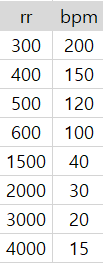

In [64]:
df_percentage_per_range_above_1000 = df_percentage_per_range[df_percentage_per_range.index >= 1000].sum()
print(f'Sum of percentages for values above 1000: {df_percentage_per_range_above_1000}')

df_percentage_per_range_under_1000 = df_percentage_per_range[df_percentage_per_range.index < 1000].sum()
print(f'Sum of percentages for values under 1000: {df_percentage_per_range_under_1000}')

Sum of percentages for values above 1000: 2.0238215094301784
Sum of percentages for values under 1000: 97.97617849056982


In [65]:
df_percentage_per_range_above_1500 = df_percentage_per_range[df_percentage_per_range.index > 1500].sum()
print(f'Sum of percentages for values above 1500: {df_percentage_per_range_above_1500}')

df_percentage_per_range_under_400 = df_percentage_per_range[df_percentage_per_range.index < 400].sum()
print(f'Sum of percentages for values under 400: {df_percentage_per_range_under_400}')

Sum of percentages for values above 1500: 0.8658998461939414
Sum of percentages for values under 400: 0.0025137242178833634


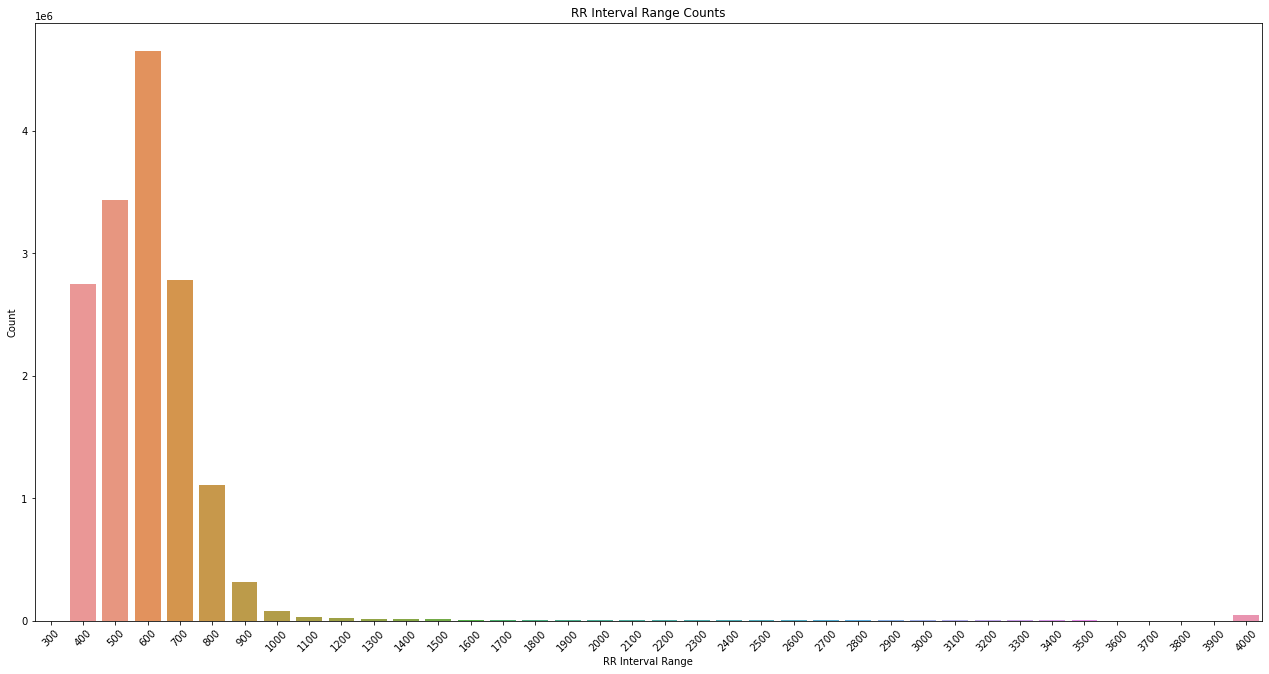

In [66]:
# le6 = 1,000,000
# 그래프 크기 설정
plt.figure(figsize=(22, 11),facecolor='white' )

# Seaborn을 사용하여 그래프 그리기
sns.countplot(data=df, x='rr_interval_range')

# 그래프 제목 설정
plt.title('RR Interval Range Counts')

# x축 라벨 설정
plt.xlabel('RR Interval Range')

# y축 라벨 설정
plt.ylabel('Count')

# x축 눈금 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.show()


In [67]:
df['m_id'].value_counts()

7A4A    543093
522E    405488
7A6E    325321
F022    280866
F006    277555
         ...  
7A52      8763
F03E       927
A856       261
F04A        20
7A22         6
Name: m_id, Length: 104, dtype: int64

In [68]:
df_7A4A = df[df['m_id'] == '7A4A']
df_7A4A

,mac,machine_id,arrhythmia,fall_detection,start_date_time,rr_interval,end_date_time,date,year,month,day,time,hour,minute,second,week,rr_interval_range,m_id
4849031,24:4C:AB:82:7A:4A,SmartPatch_7A4A,0.0,0.0,2023-09-13 10:25:14,744.0,2023-09-13 10:25:14.000,2023-09-13,2023,9,13,10:25:14,10,25,14,Wednesday,700,7A4A
4849033,24:4C:AB:82:7A:4A,SmartPatch_7A4A,0.0,0.0,2023-09-13 10:25:14,760.0,2023-09-13 10:25:15.000,2023-09-13,2023,9,13,10:25:14,10,25,14,Wednesday,700,7A4A
4849035,24:4C:AB:82:7A:4A,SmartPatch_7A4A,0.0,0.0,2023-09-13 10:25:15,2236.0,2023-09-13 10:25:17.000,2023-09-13,2023,9,13,10:25:15,10,25,15,Wednesday,2200,7A4A
4849037,24:4C:AB:82:7A:4A,SmartPatch_7A4A,0.0,0.0,2023-09-13 10:25:17,1484.0,2023-09-13 10:25:19.000,2023-09-13,2023,9,13,10:25:17,10,25,17,Wednesday,1400,7A4A
4849039,24:4C:AB:82:7A:4A,SmartPatch_7A4A,0.0,0.0,2023-09-13 10:25:19,748.0,2023-09-13 10:25:19.000,2023-09-13,2023,9,13,10:25:19,10,25,19,Wednesday,700,7A4A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16982414,24:4C:AB:82:7A:4A,SmartPatch_7A4A,1.0,1.0,2023-09-20 04:13:14,400.0,2023-09-20 04:13:14.000,2023-09-20,2023,9,20,04:13:14,4,13,14,Wednesday,400,7A4A
16982415,24:4C:AB:82:7A:4A,SmartPatch_7A4A,1.0,0.0,2023-09-20 04:13:14,400.0,2023-09-20 04:13:15.000,2023-09-20,2023,9,20,04:13:14,4,13,14,Wednesday,400,7A4A
16982416,24:4C:AB:82:7A:4A,SmartPatch_7A4A,1.0,0.0,2023-09-20 04:13:15,400.0,2023-09-20 04:13:15.000,2023-09-20,2023,9,20,04:13:15,4,13,15,Wednesday,400,7A4A
16982417,24:4C:AB:82:7A:4A,SmartPatch_7A4A,1.0,1.0,2023-09-20 04:13:15,400.0,2023-09-20 04:13:16.000,2023-09-20,2023,9,20,04:13:15,4,13,15,Wednesday,400,7A4A


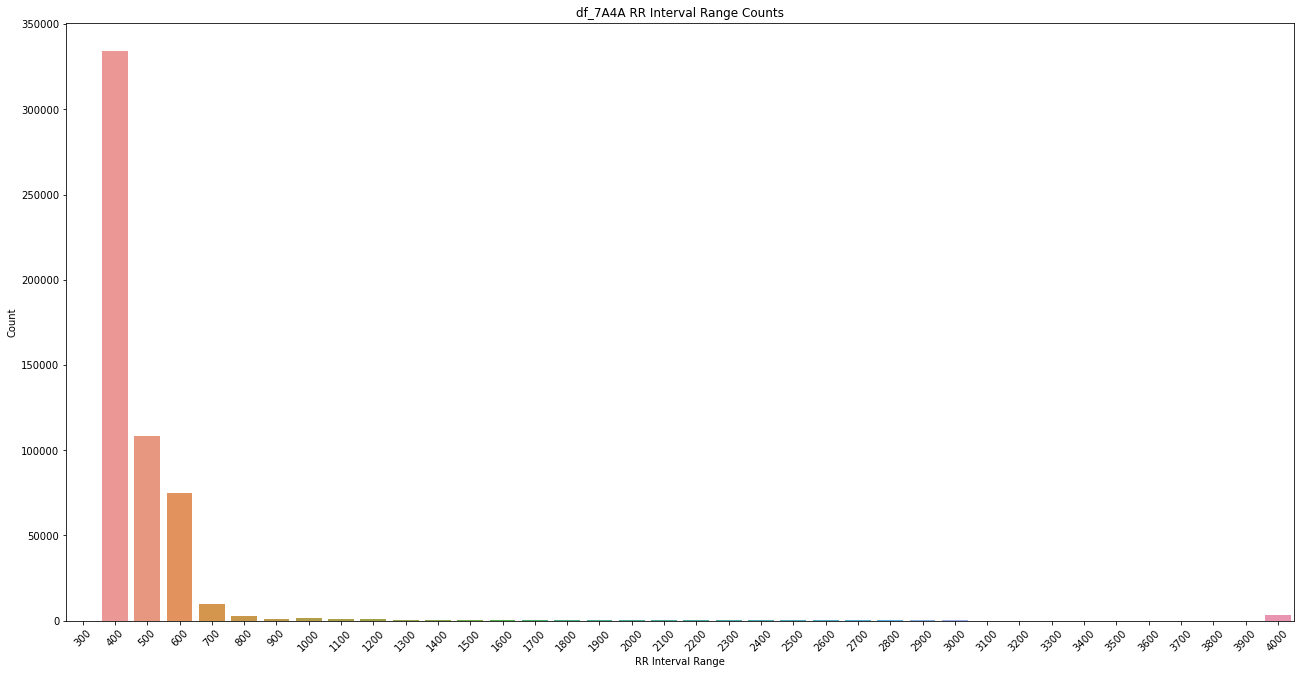

In [69]:
# le6 = 1,000,000
# 그래프 크기 설정
plt.figure(figsize=(22, 11),facecolor='white' )

# Seaborn을 사용하여 그래프 그리기
sns.countplot(data=df_7A4A, x='rr_interval_range')

# 그래프 제목 설정
plt.title('df_7A4A RR Interval Range Counts')

# x축 라벨 설정
plt.xlabel('RR Interval Range')

# y축 라벨 설정
plt.ylabel('Count')

# x축 눈금 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.show()


In [70]:
# 각 범위의 비중 계산
df_7A4A_percentage_per_range = (df_7A4A['rr_interval_range'].value_counts() / len(df_7A4A)) * 100

In [71]:
df_7A4A_percentage_per_range_above_1500 = df_7A4A_percentage_per_range[df_7A4A_percentage_per_range.index > 1500].sum()
print(f'Sum of percentages for values above 1500: {df_7A4A_percentage_per_range_above_1500}')

df_7A4A_percentage_per_range_under_400 = df_7A4A_percentage_per_range[df_7A4A_percentage_per_range.index < 400].sum()
print(f'Sum of percentages for values under 400: {df_7A4A_percentage_per_range_under_400}')

Sum of percentages for values above 1500: 1.379690034671778
Sum of percentages for values under 400: 0.00405087158184694


In [72]:
df_7A4A_percentage_per_range.sort_index()

300      0.004051
400     61.510091
500     19.944466
600     13.780697
700      1.788276
800      0.520537
900      0.208620
1000     0.253916
1100     0.196836
1200     0.150803
1300     0.092249
1400     0.083227
1500     0.086541
1600     0.082675
1700     0.076967
1800     0.057080
1900     0.052109
2000     0.055055
2100     0.044191
2200     0.048242
2300     0.036458
2400     0.034617
2500     0.030382
2600     0.026147
2700     0.034985
2800     0.025778
2900     0.023385
3000     0.026147
3100     0.020991
3200     0.018229
3300     0.018229
3400     0.017308
3500     0.017308
3600     0.015467
3700     0.016756
3800     0.013626
3900     0.013810
4000     0.573751
Name: rr_interval_range, dtype: float64